# Bayesian Model for 2 Nominal Predictors(element number, spatial pattern), Per Feature

## 1). Load required libaraies

In [2]:
#install.packages("png")

In [3]:
#Libs and File-wide Constants
library(rjags)
library(runjags)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(dplyr)
library(binr)
library(readr)
library(jsonlite)
library(LaplacesDemon)
library(mosaicCore)
testjags()

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'LaplacesDemon'


The following object is masked from 'package:runjags':

    prec2sd



Attaching package: 'mosaicCore'


The following objects are masked from 'package:LaplacesDemon':

    logit, rhs


The following objects are masked from 'package:dplyr':

    count, tally




You are using R version 4.1.3 (2022-03-10) on a windows machine, with
the RTerm GUI
JAGS version 4.3.0 found successfully using the command
'C:/Programs/JAGS/x64/bin/jags-terminal.exe'
The rjags package is installed


## 2). Define constants

In [4]:
features = c("Hue","Length","Shape")
elementNums = c("12","48", "192","768")
spatialPatterns = c("Gridded","Random")
centerOrPeriph = c("Center","Periphery")
columns_to_keep = c('PID','ReactionTime','ReactionTimeLog','Feature','ElemNum','SpatialPattern','CenterOrPeriph','Target2CenterDis')

# Specify the column names in the data file relevant to the analysis:
yName="ReactionTimeLog" 
# yName="durationLog"
# x1 should be factor with fewer levels, to plot in single pane:
x1Name="ElemNum" 
x2Name="SpatialPattern"
# Task analysis constants
# current_task=2
# current_task_short_name= all_tasks_short_names[[current_task]]
# current_analysis_name ="Main"
# current_task_name = all_tasks[[current_task]]
# cat("Active task under analysis:",current_task_name,"(",current_task,")")

displayParameters = c( "b0", "b1[1]", "b1[2]", "b1[3]", "b1[4]", "b2[1]" ,"b2[2]"
                                  #, "a1SD" , "a2SD" , "a1a2SD" ,"sigmaMode" , "sigmaSD" , "nu"
                                 )
displayAltParNames = c("intercept", "12","48", "192","768", "Gridded","Random"
                                   #, "a1SD" , "a2SD" , "a1a2SD" ,"sigmaMode" , "sigmaSD" , "nu" 
                                  )


# Path constants
mcmcDir = "calculatedMCMCs/"
resultsDir = "results/"
resultsGraphicsDir = "graphicResults/"

## 3). Include plot functions from Kruchke and Miguel

In [5]:
# Functions adapted from Kruchke's code

DbdaAcfPlot = function( codaObject , parName=varnames(codaObject)[1] , plColors=NULL ) 
{
  if ( all( parName != varnames(codaObject) ) ) { 
    stop("parName must be a column name of coda object")
  }
  nChain = length(codaObject)
  if ( is.null(plColors) ) plColors=1:nChain
  xMat = NULL
  yMat = NULL
  for ( cIdx in 1:nChain ) {
    acfInfo = acf(codaObject[,c(parName)][[cIdx]],plot=FALSE) 
    xMat = cbind(xMat,acfInfo$lag)
    yMat = cbind(yMat,acfInfo$acf)
  }
  matplot( xMat , yMat , type="o" , pch=20 , col=plColors , ylim=c(0,1) ,
           main="" , xlab="Lag" , ylab="Autocorrelation" )
  abline(h=0,lty="dashed")
  EffChnLngth = effectiveSize(codaObject[,c(parName)])
  text( x=max(xMat) , y=max(yMat) , adj=c(1.0,1.0) , cex=1.25 ,
        labels=paste("ESS =",round(EffChnLngth,1)) )
}

DbdaDensPlot = function( codaObject , parName=varnames(codaObject)[1] , plColors=NULL ) {
  if ( all( parName != varnames(codaObject) ) ) { 
    stop("parName must be a column name of coda object")
  }
  nChain = length(codaObject) # or nchain(codaObject)
  if ( is.null(plColors) ) plColors=1:nChain
  xMat = NULL
  yMat = NULL
  hdiLims = NULL
  for ( cIdx in 1:nChain ) {
    densInfo = density(codaObject[,c(parName)][[cIdx]]) 
    xMat = cbind(xMat,densInfo$x)
    yMat = cbind(yMat,densInfo$y)
    hdiLims = cbind(hdiLims,HDIofMCMC(codaObject[,c(parName)][[cIdx]]))
  }
  matplot( xMat , yMat , type="l" , col=plColors , 
           main="" , xlab="Param. Value" , ylab="Density" )
  abline(h=0)
  points( hdiLims[1,] , rep(0,nChain) , col=plColors , pch="|" )
  points( hdiLims[2,] , rep(0,nChain) , col=plColors , pch="|" )
  text( mean(hdiLims) , 0 , "95% HDI" , adj=c(0.5,-0.2) )
  EffChnLngth = effectiveSize(codaObject[,c(parName)])
  MCSE = sd(as.matrix(codaObject[,c(parName)]))/sqrt(EffChnLngth) 
  text( max(xMat) , max(yMat) , adj=c(1.0,1.0) , cex=1.25 ,
        paste("MCSE =\n",signif(MCSE,3)) )
}
    
HDIofMCMC = function( sampleVec , credMass=0.95 ) {
  # Computes highest density interval from a sample of representative values,
  #   estimated as shortest credible interval.
  # Arguments:
  #   sampleVec
  #     is a vector of representative values from a probability distribution.
  #   credMass
  #     is a scalar between 0 and 1, indicating the mass within the credible
  #     interval that is to be estimated.
  # Value:
  #   HDIlim is a vector containing the limits of the HDI
  sortedPts = sort( sampleVec )
  ciIdxInc = ceiling( credMass * length( sortedPts ) )
  nCIs = length( sortedPts ) - ciIdxInc
  ciWidth = rep( 0 , nCIs )
  for ( i in 1:nCIs ) {
    ciWidth[ i ] = sortedPts[ i + ciIdxInc ] - sortedPts[ i ]
  }
  HDImin = sortedPts[ which.min( ciWidth ) ]
  HDImax = sortedPts[ which.min( ciWidth ) + ciIdxInc ]
  HDIlim = c( HDImin , HDImax )
  return( HDIlim )
}

diagMCMC = function( codaObject , parName=varnames(codaObject)[1] ,
                     saveName=NULL , saveType="jpg", parAltName=NULL ) {
# Note: original version by Kruchke
    
  if (is.null(parAltName)) {
      parAltName = parName
  }
  DBDAplColors = c("red","green","blue","cyan","magenta","yellow","black","purple")
  # openGraph(height=5,width=7)
  par( mar=0.5+c(3,4,1,0) , oma=0.1+c(0,0,2,0) , mgp=c(2.25,0.7,0) , 
       cex.lab=1.5 )
  layout(matrix(1:4,nrow=2))
  # traceplot and gelman.plot are from CODA package:
  require(coda)
  verticalAxisName = paste("Param. Value of ",parAltName,"")
  coda::traceplot( codaObject[,c(parName)] , main="" , ylab="Param. Value" ,
                   col=DBDAplColors ) 
  tryVal = try(
    coda::gelman.plot( codaObject[,c(parName)] , main="" , auto.layout=FALSE , 
                       col=DBDAplColors )
  )  
  # if it runs, gelman.plot returns a list with finite shrink values:
  if ( class(tryVal)=="try-error" ) {
    plot.new() 
    print(paste0("Warning: coda::gelman.plot fails for ",parName))
  } else { 
    if ( class(tryVal)=="list" & !is.finite(tryVal$shrink[1]) ) {
      plot.new() 
      print(paste0("Warning: coda::gelman.plot fails for ",parName))
    }
  }
  DbdaAcfPlot(codaObject,parName,plColors=DBDAplColors)
  DbdaDensPlot(codaObject,parName,plColors=DBDAplColors)
  mtext( text=parAltName , outer=TRUE , adj=c(0.5,0.5) , cex=2.0 )
}


calcAndPlotContrasts = function(coda,dataFrame,x1Name) {
  x1levels = levels(as.factor(dataFrame[,x1Name])) 
  str(x1levels)
  matData = as.matrix(coda,chains=TRUE)    
  numericOutput = list()  
    
  for (i in 1:length(x1levels)) {
      nameCol = x1levels[i]
      numericOutput[[nameCol]] = list()
      
      for (j in 1:length(x1levels)) {
          nameRow = x1levels[j]
          
          # print(paste("i,j:",nameCol,nameRow))
          title = paste(nameCol,"-",nameRow)
          if (j>i) {
               numericOutput[[nameCol]][[nameRow]] = plotAndCalcDifference(matData=matData,i=i,j=j,title=title)
              
          }          
      }
  }
  return(numericOutput)    
}

plotAndCalcDifference = function(matData,i,j,title,varRootName = "b1",verbose = TRUE) {
    
    output = list()
    
    varName1 = paste(varRootName,"[",i,"]",sep="")
    varName2 = paste(varRootName,"[",j,"]",sep="")      
    myDiff = matData[,varName1] - matData[,varName2]
    plotPost(myDiff,main=title)
    
    # calculated variables
    probVar1Larger = mean(as.numeric(myDiff>0))
    
    output["probVar1Larger"] = probVar1Larger
    
    if (verbose) {
        print(paste(title,"probVar1Larger:",probVar1Larger))
    }
    
    return(output)
}

## 4). Read data

In [6]:
folder = "data/"
files = list.files(path = folder, pattern="*\\.csv$")

allDFList = list()

for (myFile in files) {
  myDF = read.csv(file = paste(folder,myFile,sep=""),sep=",", na.strings = c("null"))
  myDF <- subset(myDF, !is.na(ReactionTime))
  myDF$ElemNum <- factor(myDF$ElemNum)    ## Convert the 'ElemNum' column to a factor (nominal)
  allDFList[[length(allDFList)+1]]=myDF
}
df = do.call("rbind",allDFList)

df = df[columns_to_keep]

# get the dataframe for each feature
hue_df <- subset(df, Feature == "Hue")
length_df <- subset(df, Feature == "Length")
shape_df <- subset(df, Feature == "Shape")

# For debug
head(df)
# head(length_df)
# str(df)

,PID,ReactionTime,ReactionTimeLog,Feature,ElemNum,SpatialPattern,CenterOrPeriph,Target2CenterDis
,<int>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
1,3,1507.0,3.178113,Shape,768,Random,Center,0.1064987
2,3,7632.6,3.882673,Shape,768,Random,Center,0.2290965
3,3,23285.2,4.367080,Shape,768,Random,Center,0.1701157
4,3,33382.0,4.523512,Shape,768,Random,Periphery,0.6543107
5,3,7686.5,3.885729,Shape,768,Random,Center,0.2362122
6,3,5805.3,3.763825,Shape,768,Random,Periphery,0.2963505


## 5). Define the function that run MCMC model, return a coda

In [7]:
runMCMC = function(data,
                          modelString,parameters,parNames,
                          numSavedSteps=50000, thinSteps=1, 
                          nChains = 8,
                          testName="no-name",
                          mcmcDir = mcmcDir,
                          loadExistingFiles = TRUE,
                          saveCalculatedFiles = TRUE,
                          resultsDir = resultsDir,
                          # showDiag=TRUE,
                          # saveDiag=TRUE,
                          # showPostGraphs = TRUE,
                          # savePostGraphs = TRUE,
                          # showNumericResults = TRUE,
                          # saveNumericResults = TRUE,
                          silent = FALSE
                         ) 
{
    
    fileNameRJO = paste(mcmcDir,testName,"-",numSavedSteps*thinSteps,".rjr",sep="")
    fileNameCoda = paste(mcmcDir,testName,"-",numSavedSteps*thinSteps,".coda",sep="")
    fileNameData = paste(mcmcDir,testName,"-",numSavedSteps*thinSteps,".data",sep="")
    
    rjo=NULL
    coda=NULL
    dataIn = NULL
    
    numeric_results = list()
    
    computeNewMCMC = TRUE
    
    # Check if existing files for this run exist
    if (loadExistingFiles) 
    {
        if(file.exists(fileNameRJO) && file.exists(fileNameCoda) && file.exists(fileNameData)) 
        { 
            rjo = readRDS(fileNameRJO)
            print(paste("RJO file found and loaded: ",fileNameRJO))
            coda = readRDS(fileNameCoda)
            print(paste("Coda file found and loaded: ",fileNameCoda))
            dataIn = readRDS(fileNameData)
            print(paste("Data file found and loaded: ",fileNameData))
            
            computeNewMCMC = FALSE
            
        } 
        else 
            dataIn = data
    }
    
    if(computeNewMCMC) 
    {
        writeLines(modelString,con="TEMPmodel.txt")
        adaptSteps = 1000 
        burnInSteps = 2000 
        # run.jags is a method provided by runjags, which supports to run parallel chains in JAGS
        rjo <- run.jags( method="parallel" ,
                          model="TEMPmodel.txt" , 
                          monitor=parameters , 
                          data=dataIn ,  
                          #inits=initsList , 
                          n.chains=nChains ,
                          adapt=adaptSteps ,
                          burnin=burnInSteps , 
                          sample=ceiling(numSavedSteps/nChains) , # specify the number of steps
                          thin=thinSteps ,
                          summarise=TRUE , # whether or not to compute diagnostic statistics for every parameter.
                          modules ="glm",
                          silent.jags = silent,
                          plots=FALSE )
        coda = as.mcmc.list( rjo )
        
        saveRDS(rjo,fileNameRJO)
        saveRDS(coda,fileNameCoda)
        saveRDS(dataIn,fileNameData)
    }  
    return(coda)
}

## 6) Define the function that plots coda results

In [8]:
plotMCMC = function( codaSamples , 
                     datFrm , yName="y" , x1Name="x1" , x2Name="x2" ,
                     x1contrasts=NULL , 
                     x2contrasts=NULL , 
                     x1x2contrasts=NULL ,
                     saveName=NULL , saveType="jpg" ) 
{
  mcmcMat = as.matrix(codaSamples,chains=TRUE)
  chainLength = NROW( mcmcMat )
  y = datFrm[,yName]
  x1 = as.numeric(as.factor(datFrm[,x1Name]))
  x1levels = levels(as.factor(datFrm[,x1Name]))
  x2 = as.numeric(as.factor(datFrm[,x2Name]))
  x2levels = levels(as.factor(datFrm[,x2Name]))
  # Display data with posterior predictive distributions
  for ( x2idx in 1:length(x2levels) ) {
    #openGraph(width=1.2*length(x1levels),height=5)
    par( mar=c(4,4,2,1) , mgp=c(3,1,0) )
    plot(-10,-10, 
         xlim=c(0.2,length(x1levels)+0.1) , 
         xlab=paste(x1Name,x2Name,sep="\n") , 
         xaxt="n" , ylab=yName ,
         ylim=c(min(y)-0.2*(max(y)-min(y)),max(y)+0.2*(max(y)-min(y))) ,
         main="Data with Post. Pred.")
    axis( 1 , at=1:length(x1levels) , tick=FALSE ,
          lab=paste( x1levels , x2levels[x2idx] , sep="\n" ) )
    for ( x1idx in 1:length(x1levels) ) {
      xPlotVal = x1idx #+ (x2idx-1)*length(x1levels)
      yVals = y[ x1==x1idx & x2==x2idx ]
      points( rep(xPlotVal,length(yVals))+runif(length(yVals),-0.05,0.05) , 
              yVals , pch=1 , cex=1.5 , col="red" )
      chainSub = round(seq(1,chainLength,length=20))
      for ( chnIdx in chainSub ) {
        m = mcmcMat[chnIdx,paste0("m[",x1idx,",",x2idx,"]")]
        s = mcmcMat[chnIdx,paste0("ySigma[",x1idx,",",x2idx,"]")]
        n = mcmcMat[chnIdx,"nu"]

        tlim = qt( c(0.025,0.975) , df=n )
        yl = m+tlim[1]*s
        yh = m+tlim[2]*s
        ycomb=seq(yl,yh,length=201)
        yt = dt( (ycomb-m)/s , df=n )
        yt = 0.67*yt/max(yt)
        lines( xPlotVal-yt , ycomb , col="skyblue" ) 
        
      }
    }
    if ( !is.null(saveName) ) {
      saveGraph( file=paste0(saveName,"PostPred-",x2levels[x2idx]), type=saveType)
    }
  } # end for x2idx

  # Display the normality and top-level variance parameters:
  #openGraph(width=8,height=3)
  layout( matrix(1:3,nrow=1) )
  par( mar=c(4,4,2,1) , mgp=c(3,1,0) )
  compInfo = plotPost( log10(mcmcMat[,"nu"]) , xlab=expression("log10("*nu*")") ,
                       main="Normality", compVal=NULL , ROPE=NULL )
  compInfo = plotPost( mcmcMat[,"sigmaMode"] , xlab="param. value" ,
                       main="Mode of Cell Sigma's", compVal=NULL , ROPE=NULL )
  compInfo = plotPost( mcmcMat[,"sigmaSD"] , xlab="param. value" ,
                       main="SD of Cell Sigma's", compVal=NULL , ROPE=NULL )
  if ( !is.null(saveName) ) {
    saveGraph( file=paste0(saveName,"NuSigmaMode"), type=saveType)
  }
  
  # plot contrasts:
  if ( !is.null(x1contrasts) | !is.null(x2contrasts) | !is.null(x1x2contrasts) ) {
    if ( is.null(datFrm) | is.null(x1Name) | is.null(x2Name) ) {
      show(" *** YOU MUST SPECIFY THE DATA FILE AND FACTOR NAMES TO DO CONTRASTS. ***\n")
    } else {
      x1 = as.numeric(as.factor(datFrm[,x1Name]))
      x1levels = levels(as.factor(datFrm[,x1Name]))
      x2 = as.numeric(as.factor(datFrm[,x2Name]))
      x2levels = levels(as.factor(datFrm[,x2Name]))
      # x1 contrasts:
      if ( !is.null(x1contrasts) ) {
        for ( cIdx in 1:length(x1contrasts) ) {
          thisContrast = x1contrasts[[cIdx]]
          left = right = rep(FALSE,length(x1levels))
          for ( nIdx in 1:length( thisContrast[[1]] ) ) { 
            left = left | x1levels==thisContrast[[1]][nIdx]
          }
          left = normalize(left)
          for ( nIdx in 1:length( thisContrast[[2]] ) ) { 
            right = right | x1levels==thisContrast[[2]][nIdx]
          }
          right = normalize(right)
          contrastCoef = matrix( left-right , ncol=1 )
          postContrast = ( mcmcMat[,paste("b1[",1:length(x1levels),"]",sep="")] 
                           %*% contrastCoef )
          openGraph(height=4,width=4)
          compInfo = plotPost( postContrast , xlab="Difference" ,
                               main=paste0( 
                                 paste(thisContrast[[1]],collapse="."), 
                                 "\nvs\n",
                                 paste(thisContrast[[2]],collapse=".") ),
                               compVal=thisContrast$compVal ,
                               ROPE=thisContrast$ROPE )
          saveGraph(file=paste0(saveName,
                                paste(thisContrast[[1]],collapse="."), 
                                "-vs-",
                                paste(thisContrast[[2]],collapse=".")),
                    type=graphFileType)
        }
      }
      # x2 contrasts:
      if ( !is.null(x2contrasts) ) {
        for ( cIdx in 1:length(x2contrasts) ) {
          thisContrast = x2contrasts[[cIdx]]
          left = right = rep(FALSE,length(x2levels))
          for ( nIdx in 1:length( thisContrast[[1]] ) ) { 
            left = left | x2levels==thisContrast[[1]][nIdx]
          }
          left = normalize(left)
          for ( nIdx in 1:length( thisContrast[[2]] ) ) { 
            right = right | x2levels==thisContrast[[2]][nIdx]
          }
          right = normalize(right)
          contrastCoef = matrix( left-right , ncol=1 )
          postContrast = ( mcmcMat[,paste("b2[",1:length(x2levels),"]",sep="")] 
                           %*% contrastCoef )
          openGraph(height=4,width=4)
          compInfo = plotPost( postContrast , xlab="Difference" ,
                               main=paste0( 
                                 paste(thisContrast[[1]],collapse="."), 
                                 "\nvs\n",
                                 paste(thisContrast[[2]],collapse=".") ),
                               compVal=thisContrast$compVal ,
                               ROPE=thisContrast$ROPE )
          saveGraph(file=paste0(saveName,
                                paste(thisContrast[[1]],collapse="."), 
                                "-vs-",
                                paste(thisContrast[[2]],collapse=".")),
                    type=graphFileType)
        }
      }
      # interaction contrasts:
      if ( !is.null(x1x2contrasts) ) {
        for ( cIdx in 1:length(x1x2contrasts) ) {
          thisContrast = x1x2contrasts[[cIdx]]
          # factor A contrast:
          facAcontrast = thisContrast[[1]]
          facAcontrastLeft = facAcontrast[[1]]
          facAcontrastRight = facAcontrast[[2]]
          left = right = rep(FALSE,length(x1levels))
          for ( nIdx in 1:length( facAcontrastLeft ) ) { 
            left = left | x1levels==facAcontrastLeft[nIdx]
          }
          left = normalize(left)
          for ( nIdx in 1:length( facAcontrastRight ) ) { 
            right = right | x1levels==facAcontrastRight[nIdx]
          }
          right = normalize(right)
          facAcontrastCoef = left-right
          # factor B contrast:
          facBcontrast = thisContrast[[2]]
          facBcontrastLeft = facBcontrast[[1]]
          facBcontrastRight = facBcontrast[[2]]
          left = right = rep(FALSE,length(x2levels))
          for ( nIdx in 1:length( facBcontrastLeft ) ) { 
            left = left | x2levels==facBcontrastLeft[nIdx]
          }
          left = normalize(left)
          for ( nIdx in 1:length( facBcontrastRight ) ) { 
            right = right | x2levels==facBcontrastRight[nIdx]
          }
          right = normalize(right)
          facBcontrastCoef = left-right
          # interaction contrast:
          contrastCoef = cbind( as.vector( 
            outer( facAcontrastCoef , facBcontrastCoef ) ) )
          postContrast = ( mcmcMat[,substr(colnames(mcmcMat),1,5)=="b1b2["] 
                           %*% contrastCoef )
          mainName = paste0(
            paste0(paste(thisContrast[[1]][[1]],collapse="."), 
                   ".v.",
                   paste(thisContrast[[1]][[2]],collapse=".")),
            "\n(x)\n",
            paste0(paste(thisContrast[[2]][[1]],collapse="."), 
                   ".v.",
                   paste(thisContrast[[2]][[2]],collapse=".")))
          openGraph(height=4,width=4)
          compInfo = plotPost( postContrast , xlab="Difference of Differences" ,
                               main=mainName ,
                               compVal=thisContrast$compVal ,
                               ROPE=thisContrast$ROPE )
          fileNameSuffix = paste0(
            paste0(paste(thisContrast[[1]][[1]],collapse="."), 
                   ".v.",
                   paste(thisContrast[[1]][[2]],collapse=".")),
            "(x)",
            paste0(paste(thisContrast[[2]][[1]],collapse="."), 
                   ".v.",
                   paste(thisContrast[[2]][[2]],collapse=".")))
          saveGraph(file=paste0(saveName,fileNameSuffix),
                    type=graphFileType)
        }
      } # end of interaction contrasts
    }  
  } # end plot contrasts
}

## 7). Define the model and all needed information

###  7.1) Model with interaction for ReactionTimeLog

In [9]:
twoFactsModel = "
  model {
    for ( i in 1:Ntotal ) {
      y[i] ~ dt( mu[i] , 1/(ySigma[x1[i],x2[i]])^2 , nu ) # likehood
      mu[i] <- a0 + a1[x1[i]] + a2[x2[i]] + a1a2[x1[i],x2[i]]
    }
    # For sparse data with lots of outliers, there can be multimodal small-nu
    # estimates, in which case you may want to change the prior to force a 
    # larger value of nu, such as  nu ~ dgamma(5.83,0.0483)  mode 100, sd 50


    ### Priori definitions
    # priori for nu
    # nu: the “normality” parameter, range from 1 to infinite.
    nu ~ dexp(1/30.0)  #This line equals to:  nu <- nuMinusOne+1 and nuMinusOne ˜ dexp(1/29)
    #
    # priori for sigma
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) { 
      sigma[j1,j2] ~ dgamma( sigmaSh , sigmaRa )
      # Prevent from dropping too close to zero:
      ySigma[j1,j2] <- max( sigma[j1,j2] , medianCellSD/1000 )
    } }
    sigmaSh <- 1 + sigmaMode * sigmaRa
    sigmaRa <- ( sigmaMode + sqrt( sigmaMode^2 + 4*sigmaSD^2 ) ) /(2*sigmaSD^2)
    sigmaMode ~ dgamma(sGammaShRa[1],sGammaShRa[2]) 
    sigmaSD ~ dgamma(sGammaShRa[1],sGammaShRa[2]) 
    # priori for mu, which consists of a0, a1, a2, a1a2
    a0 ~ dnorm( yMean , 1/(ySD*5)^2 ) 
    #
    for ( j1 in 1:Nx1Lvl ) { a1[j1] ~ dnorm( 0.0 , 1/a1SD^2 ) }
    a1SD ~ dgamma(aGammaShRa[1],aGammaShRa[2]) 
    #
    for ( j2 in 1:Nx2Lvl ) { a2[j2] ~ dnorm( 0.0 , 1/a2SD^2 ) }
    a2SD ~ dgamma(aGammaShRa[1],aGammaShRa[2]) 
    #
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      a1a2[j1,j2] ~ dnorm( 0.0 , 1/a1a2SD^2 )
    } }
    a1a2SD ~ dgamma(aGammaShRa[1],aGammaShRa[2]) # or try a folded t (Cauchy)
    # Convert a0,a1[],a2[],a1a2[,] to sum-to-zero b0,b1[],b2[],b1b2[,] :
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      m[j1,j2] <- a0 + a1[j1] + a2[j2] + a1a2[j1,j2] # cell means 
    } }
    b0 <- mean( m[1:Nx1Lvl,1:Nx2Lvl] )
    for ( j1 in 1:Nx1Lvl ) { b1[j1] <- mean( m[j1,1:Nx2Lvl] ) - b0 }
    for ( j2 in 1:Nx2Lvl ) { b2[j2] <- mean( m[1:Nx1Lvl,j2] ) - b0 }
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
          b1b2[j1,j2] <- m[j1,j2] - ( b0 + b1[j1] + b2[j2] )  
        } }
  }
  "

### 7.2). Function that gets parameters and data for YmetXnom2fac model

In [15]:
modelParas = function(featureID, dataFrame)
    {
    currentFeature = features[featureID]
    currentdf = dataFrame
    # Calculation for external data of this model

      #------------------------------------------------------------------------------
      # THE DATA.
      # Convert data file columns to generic x,y variable names for model:
      # y should be numeric
      y = as.numeric(currentdf[,yName])  
      # x1, x2 should be factor (nominal)
      x1 = as.numeric(as.factor(currentdf[,x1Name]))
      x2 = as.numeric(as.factor(currentdf[,x2Name]))
      x1levels = levels(as.factor(currentdf[,x1Name]))
      x2levels = levels(as.factor(currentdf[,x2Name]))
      Ntotal = length(y)
      Nx1Lvl = length(unique(x1))
      Nx2Lvl = length(unique(x2))
      # Compute scale properties of data, for passing into prior to make the prior
      # vague on the scale of the data. 
      # For prior on baseline, etc.:
      yMean = mean(y)
      ySD = sd(y)
      # For prior on deflections:
      aGammaShRa = unlist( gammaShRaFromModeSD( mode=sd(y)/2 , sd=2*sd(y) ) )
      # For prior on cell SDs:
      cellSDs = aggregate( y , list(x1,x2) , FUN=sd )
      cellSDs = cellSDs[ !is.na(cellSDs$x) ,]
      medianCellSD = median( cellSDs$x , na.rm=TRUE )
      sdCellSD = sd( cellSDs$x , na.rm=TRUE )
    
      sGammaShRa = unlist( gammaShRaFromModeSD( mode=medianCellSD , sd=2*sdCellSD ) )
      # Specify the data in a list for sending to JAGS:
      twoFactsDataList = list(
        y = y ,
        x1 = x1 ,
        x2 = x2 ,
        Ntotal = Ntotal ,
        Nx1Lvl = Nx1Lvl ,
        Nx2Lvl = Nx2Lvl ,
        # data properties for scaling the prior:
        yMean = yMean ,
        ySD = ySD ,
        medianCellSD = medianCellSD ,
        aGammaShRa = aGammaShRa ,
        sGammaShRa = sGammaShRa
        #a1SD = ySD*5 , #sufficiently large
        #a2SD = ySD*5 #sufficiently large
      )
 
    twoFactsParameters = c( "b0", "b1", "b1[1]", "b1[2]", "b1[3]", "b1[4]", "b2[1]" ,"b2[2]", "b1b2" , "m"
                                  , "a1SD" , "a2SD" , "a1a2SD" ,"ySigma","sigmaMode" , "sigmaSD" , "nu" 
                                 )
    
    #numSteps = 10000*20*7+2 # num Steps to be updated to achieve ESS of at least 10000.
    numSteps = 10001 #for testing
    testName = paste(currentFeature, "-",x1Name,"-",x2Name,"-",yName,"-","noint",sep="") # location data of the variable y without interactions
    paras <- list(twoFactsDataList = twoFactsDataList, twoFactsParameters = twoFactsParameters, numSteps = numSteps,testName = testName)
    return (paras)
}

### 7.3). Function that summarize and plot Bayesian models

In [11]:
summaryAndPlot = function(paras, mcmcCoda, datFrm)
{
    summaryInfo = smryMCMC(mcmcCoda, datFrm=datFrm, x1Name=x1Name , x2Name=x2Name)
    show(summaryInfo)
    # Save summary Info
    write.table(summaryInfo, file = paste(resultsDir, paras$testName, ".txt"), sep = "\t", quote = FALSE)
    
    parameterNames = varnames(mcmcCoda) 
    show( parameterNames ) # show all parameter names, for reference
    for (i in 1:length(displayParameters)) 
    {
        diagMCMC( codaObject = mcmcCoda , parName = displayParameters[i], parAltName = displayAltParNames[i])
    }
    #figureSaveName = paste(resultsGraphicsDir, currentFeature, "-",x1Name,"-",x2Name)
    plotMCMC( mcmcCoda , datFrm=datFrm , yName=yName , x1Name=x1Name , x2Name=x2Name)
}

## 8). Run YmetXnom2fac model for all features

### 8.1). Hue

In [16]:
paras_H = modelParas(1, hue_df)
mcmcCoda_H = runMCMC(data = paras_H$twoFactsDataList, modelString = twoFactsModel,
                            parameters = paras_H$twoFactsParameters,
                            parNames = NULL,
                            numSavedSteps = paras_H$numSteps, thinSteps=1,
                            testName = paras_H$testName,
                            mcmcDir=mcmcDir,
                            resultsDir=resultsDir
                            )

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."
module lecuyer loaded



Calling 8 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Jan 01 19:57:30 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. Loading module: glm: ok
. Loading module: lecuyer: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 507
   Unobserved stochastic nodes: 29
   Total graph size: 1656
. Reading parameter file inits1.txt
. Initializing model
. Adapting 1000
-------------------------------------------------| 1000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation successful
. Updating 2000
-------------------------------------------------| 2000
************************************************** 100%
. . . . . . . . . . . . . . Updating 1251
----------------------------

### 8.2). Length

In [18]:
paras_L = modelParas(2, length_df)
mcmcCoda_L = runMCMC(data = paras_L$twoFactsDataList, modelString = twoFactsModel,
                            parameters = paras_L$twoFactsParameters,
                            parNames = NULL,
                            numSavedSteps = paras_L$numSteps, thinSteps=1,
                            testName = paras_L$testName,
                            mcmcDir=mcmcDir,
                            resultsDir=resultsDir
                            )

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 8 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Jan 01 20:00:16 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. Loading module: glm: ok
. Loading module: lecuyer: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 502
   Unobserved stochastic nodes: 29
   Total graph size: 1641
. Reading parameter file inits1.txt
. Initializing model
. Adapting 1000
-------------------------------------------------| 1000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation successful
. Updating 2000
-------------------------------------------------| 2000
************************************************** 100%
. . . . . . . . . . . . . . Updating 1251
----------------------------

### 8.3). Shape

In [19]:
paras_S = modelParas(3, shape_df)
mcmcCoda_S = runMCMC(data = paras_S$twoFactsDataList, modelString = twoFactsModel,
                            parameters = paras_S$twoFactsParameters,
                            parNames = NULL,
                            numSavedSteps = paras_S$numSteps, thinSteps=1,
                            testName = paras_S$testName,
                            mcmcDir=mcmcDir,
                            resultsDir=resultsDir
                            )

Warning message:
"No initial values were provided - JAGS will use the same initial values for all chains"
Warning message:
"You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values."


Calling 8 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Mon Jan 01 20:01:18 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. Loading module: glm: ok
. Loading module: lecuyer: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 489
   Unobserved stochastic nodes: 29
   Total graph size: 1602
. Reading parameter file inits1.txt
. Initializing model
. Adapting 1000
-------------------------------------------------| 1000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation successful
. Updating 2000
-------------------------------------------------| 2000
************************************************** 100%
. . . . . . . . . . . . . . Updating 1251
----------------------------

## 9). Show analysis results

### 9.1). Show hue analysis results

                               Mean      Median        Mode    ESS HDImass
b0                       2.65787426  2.65772000  2.65723691 7320.0    0.95
b1[1] 12                -0.03815710 -0.03803090 -0.03685053 4006.9    0.95
b1[2] 48                 0.01027657  0.01024460  0.01053635 8357.6    0.95
b1[3] 192               -0.02033443 -0.02027635 -0.02040932 6449.1    0.95
b1[4] 768                0.04821496  0.04807900  0.04672474 3180.1    0.95
b2[1] Gridded           -0.01122573 -0.01107650 -0.01023078 5806.6    0.95
b2[2] Random             0.01122573  0.01107650  0.01023078 5806.6    0.95
b1b2[1,1] 12 Gridded    -0.03037797 -0.03033425 -0.03252149 2127.7    0.95
b1b2[2,1] 48 Gridded    -0.01332455 -0.01300765 -0.01096138 4529.1    0.95
b1b2[3,1] 192 Gridded    0.02517016  0.02494830  0.02732800 4029.9    0.95
b1b2[4,1] 768 Gridded    0.01853236  0.01798250  0.01797667 2443.1    0.95
b1b2[1,2] 12 Random      0.03037797  0.03033425  0.03252149 2127.7    0.95
b1b2[2,2] 48 Random      

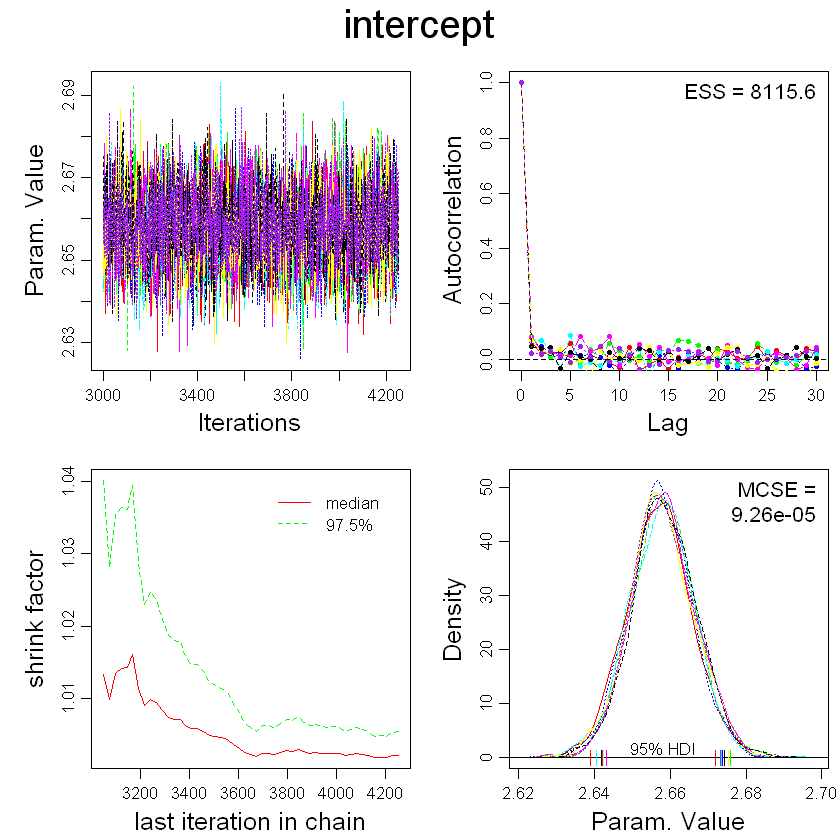

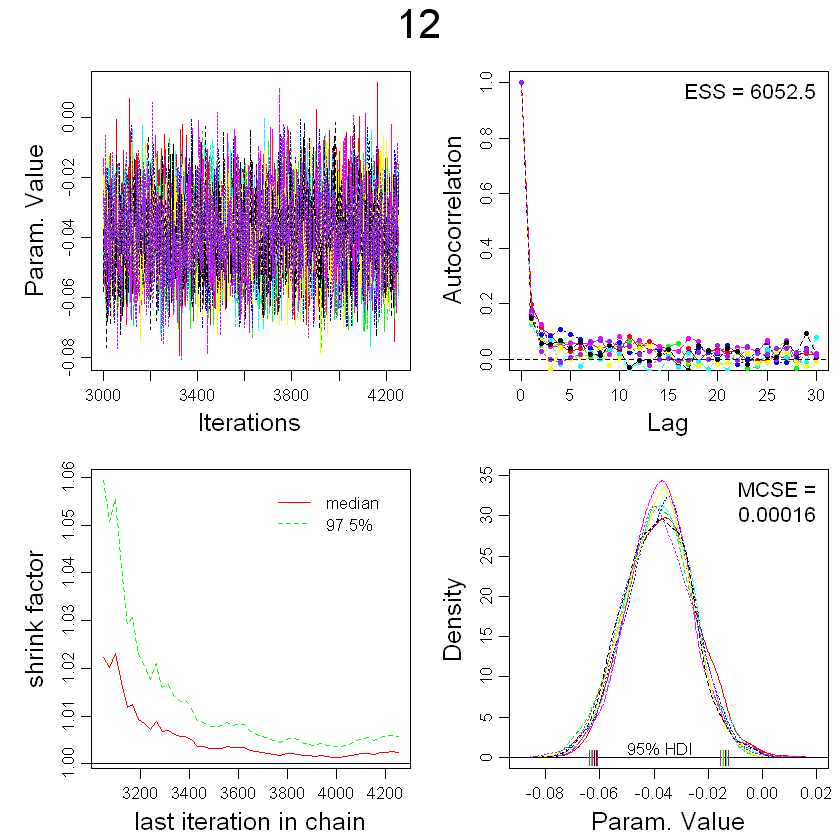

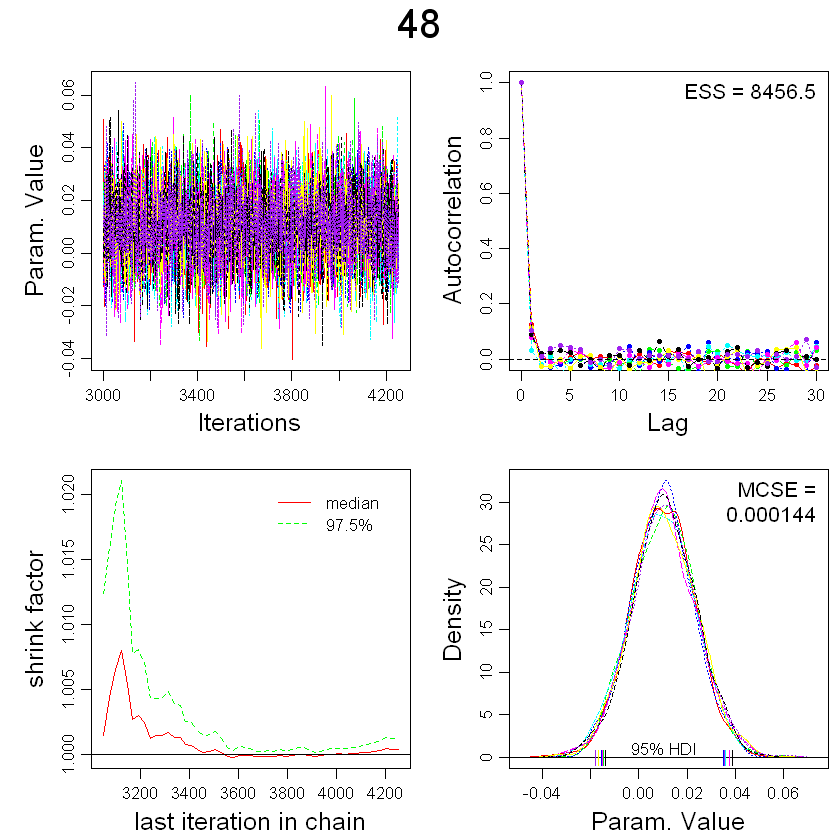

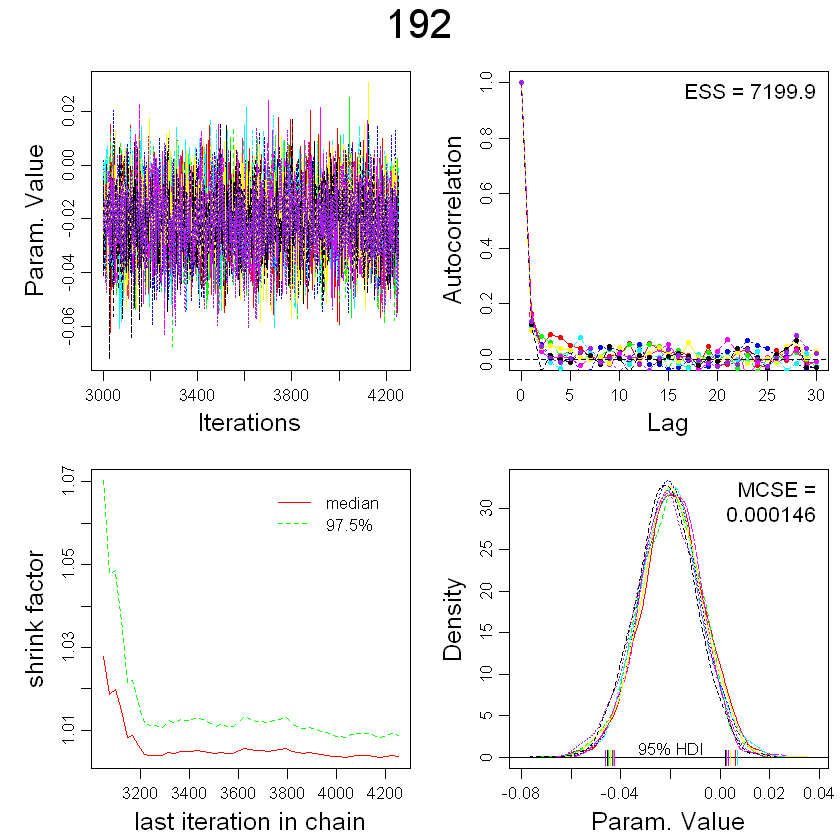

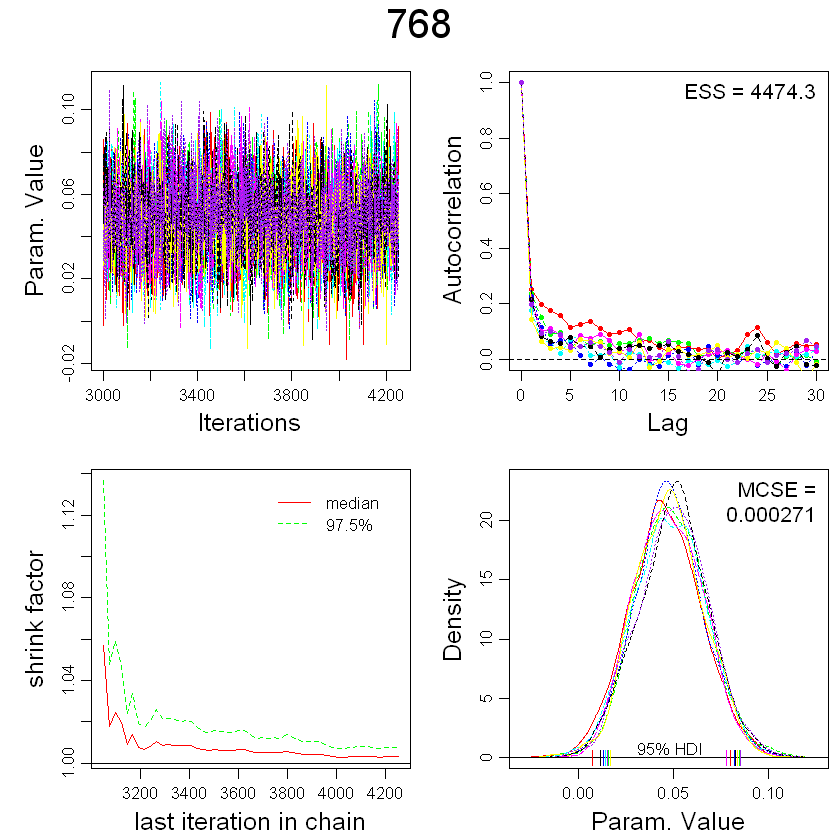

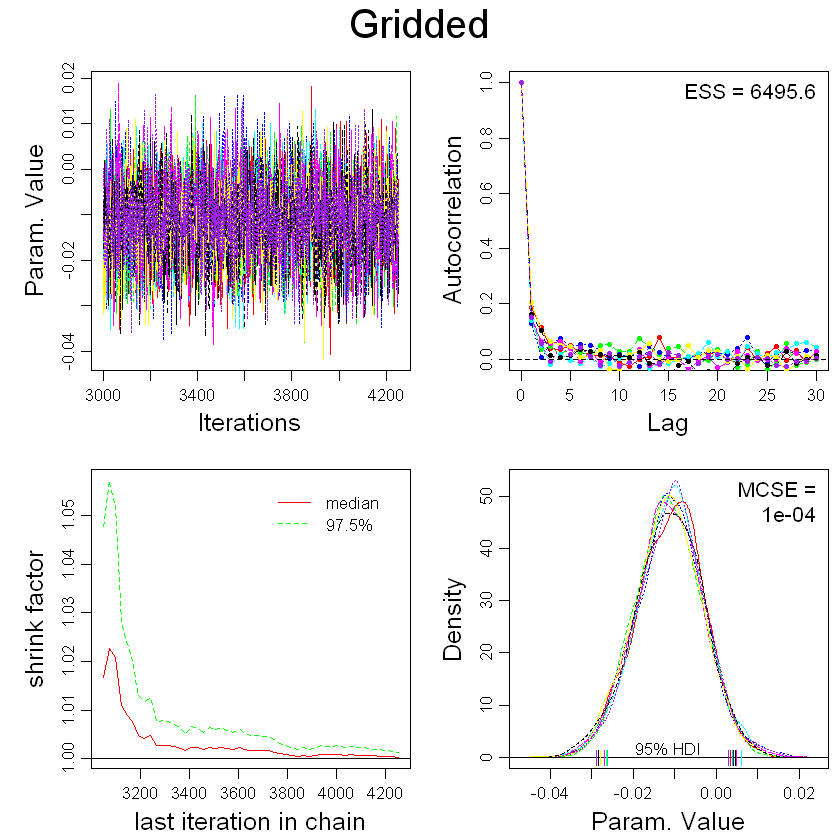

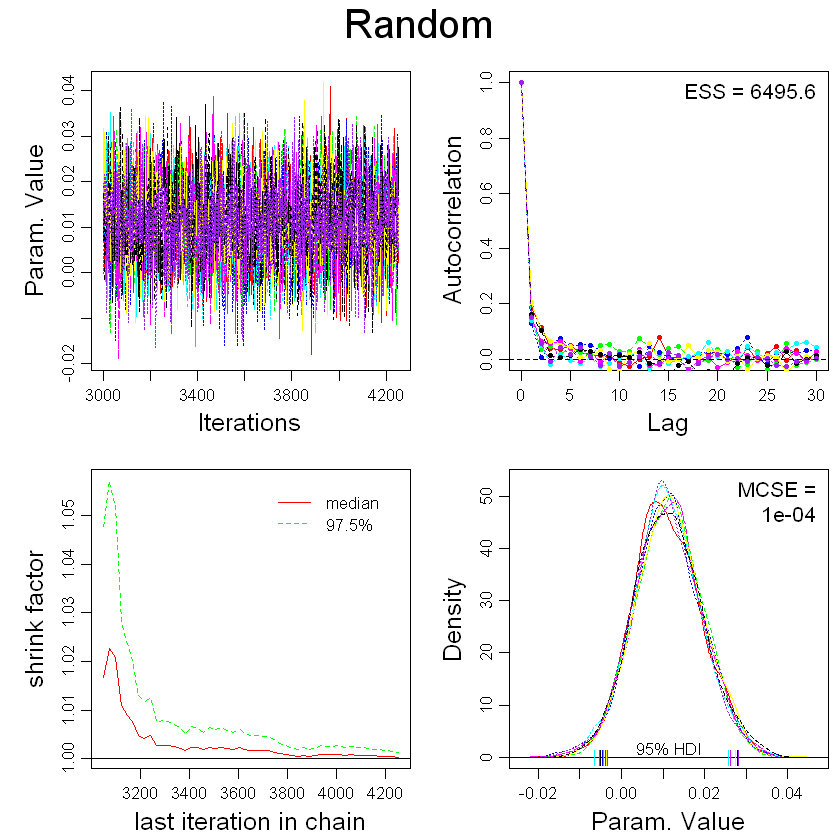

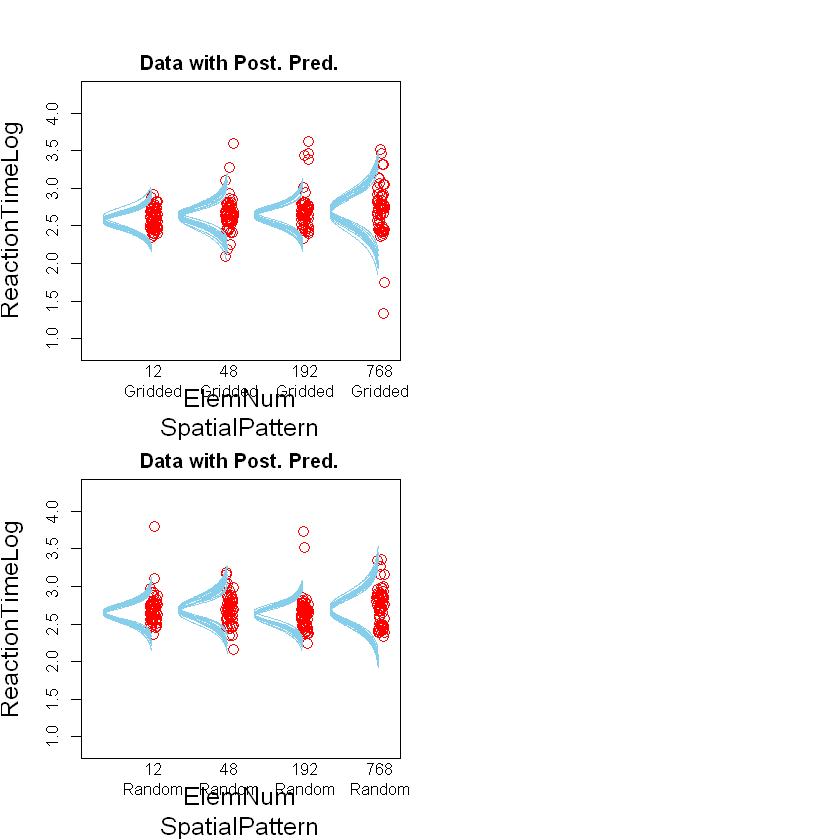

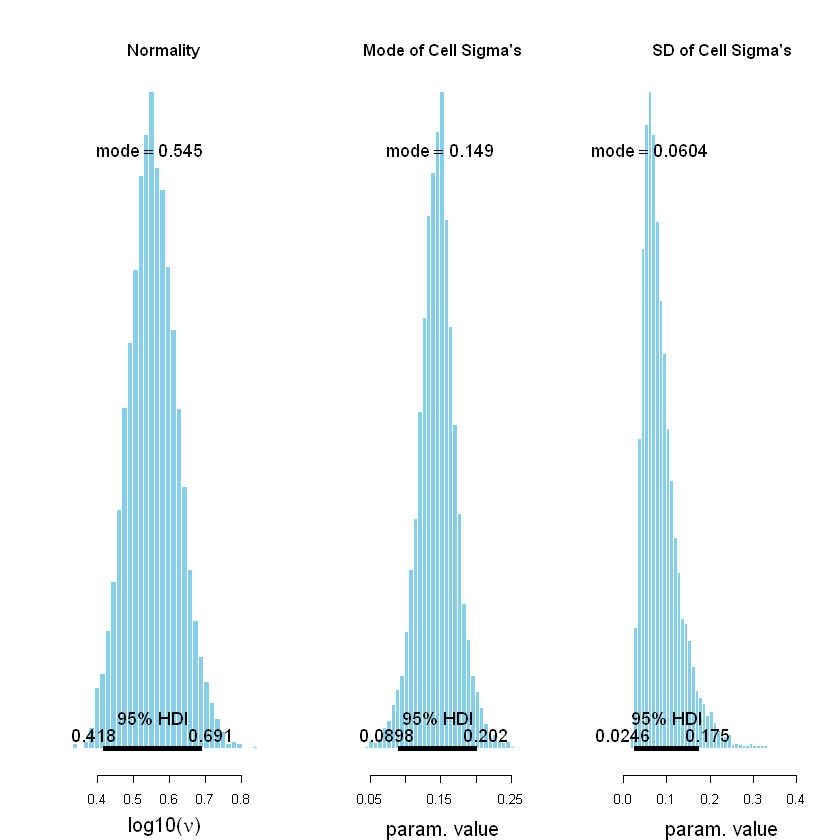

In [17]:
summaryAndPlot(paras_H, mcmcCoda_H, hue_df)

### 9.2). Show length analysis results

                    Mean      Median        Mode    ESS HDImass       HDIlow
b0             3.0940631  3.09417500  3.09341360 5086.8    0.95  3.068990000
b1[1] 12      -0.2991006 -0.29907450 -0.30018604 6827.4    0.95 -0.328628000
b1[2] 48      -0.1511897 -0.15114350 -0.15038258 7624.7    0.95 -0.188973000
b1[3] 192      0.0813768  0.08133155  0.08141949 8428.4    0.95  0.037427800
b1[4] 768      0.3689135  0.36907900  0.36935098 6379.2    0.95  0.313079000
b2[1] Gridded -0.1181019 -0.11799950 -0.11718991 3188.7    0.95 -0.144517000
b2[2] Random   0.1181019  0.11799950  0.11718991 3188.7    0.95  0.094266700
a1SD           0.2949790  0.25297850  0.20710014  186.9    0.95  0.000667742
a2SD           0.4094013  0.29795950  0.15370789  174.6    0.95  0.000441527
a1a2SD         0.2819401  0.25026050  0.18552704   86.8    0.95  0.083514900
sigmaMode      0.1899970  0.19235650  0.19823162 5194.1    0.95  0.081733100
sigmaSD        0.1696890  0.15328600  0.12594242 2463.5    0.95  0.069568100

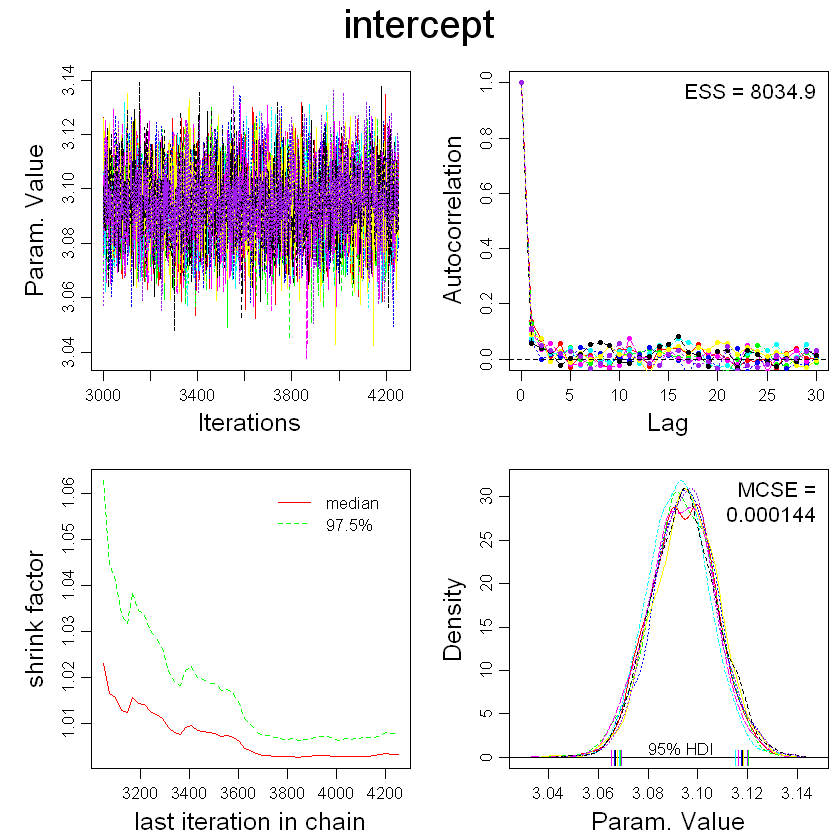

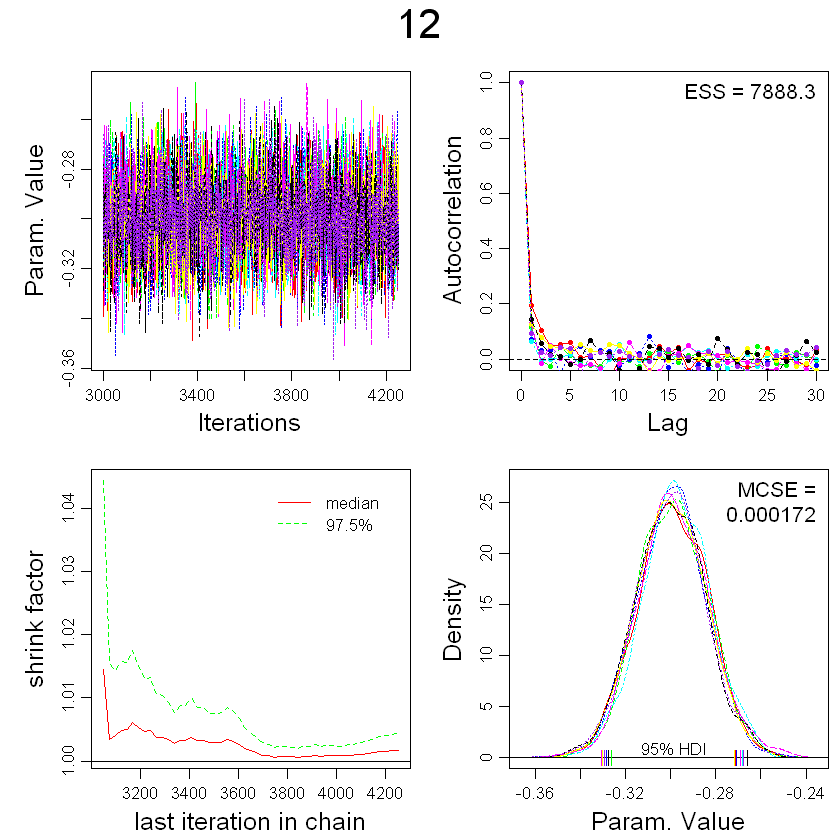

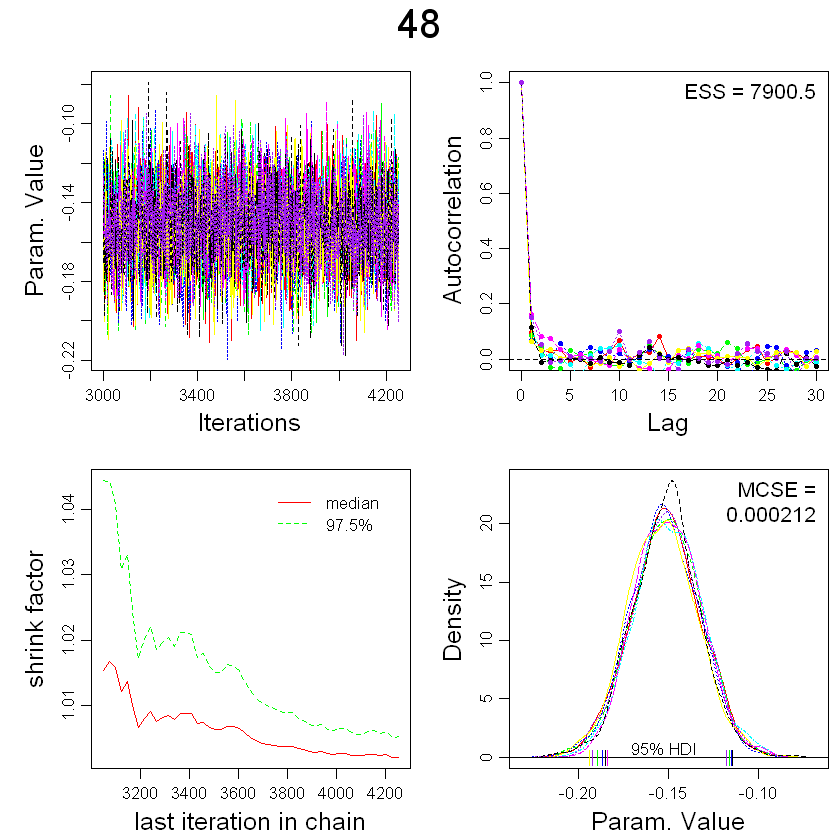

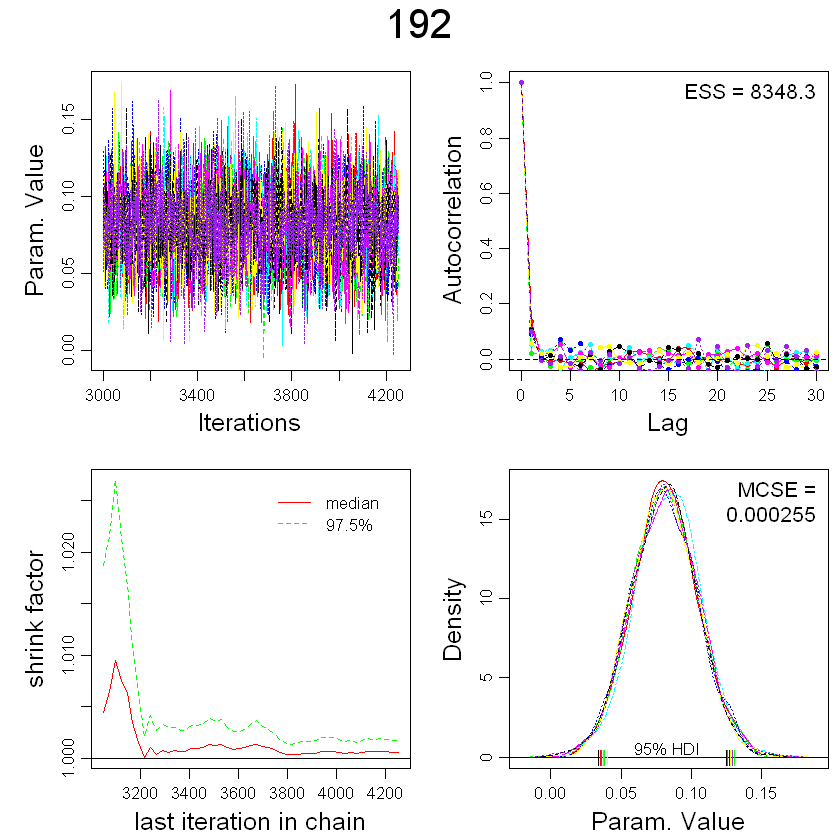

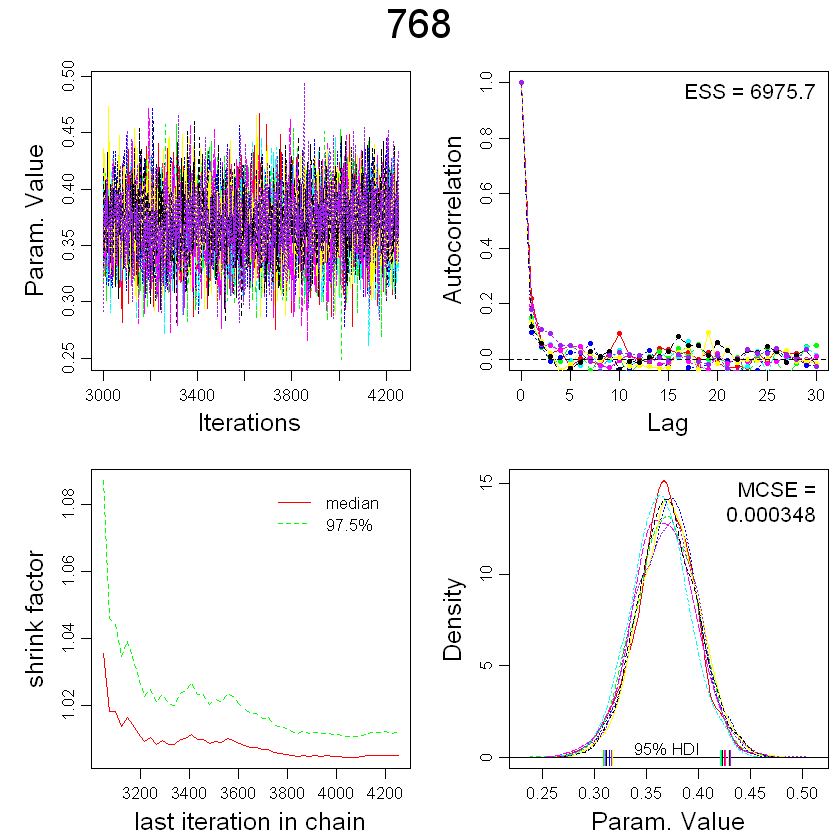

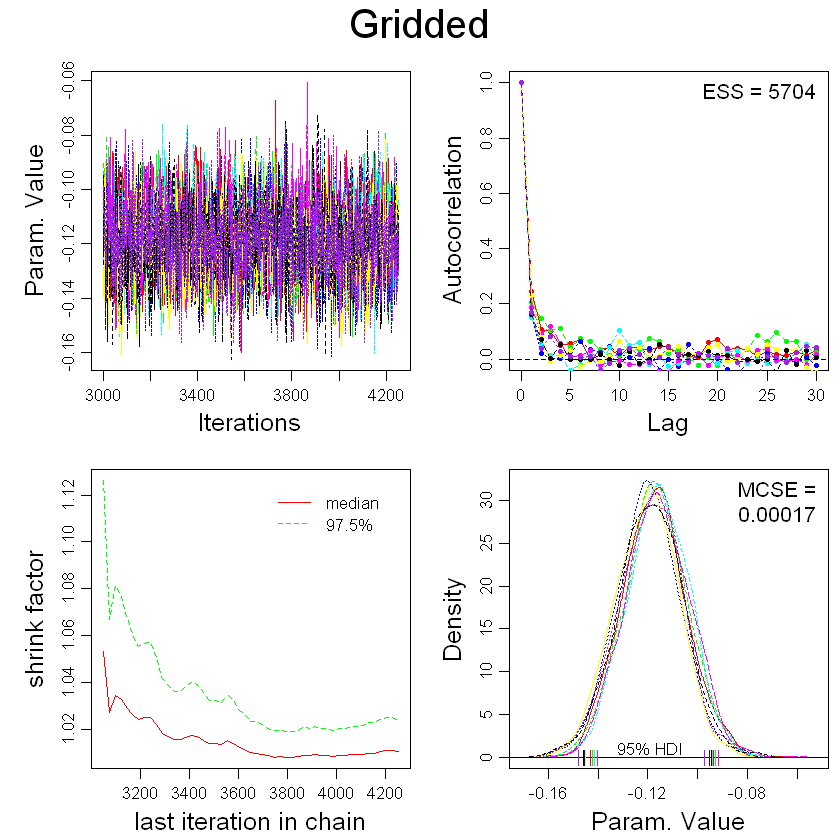

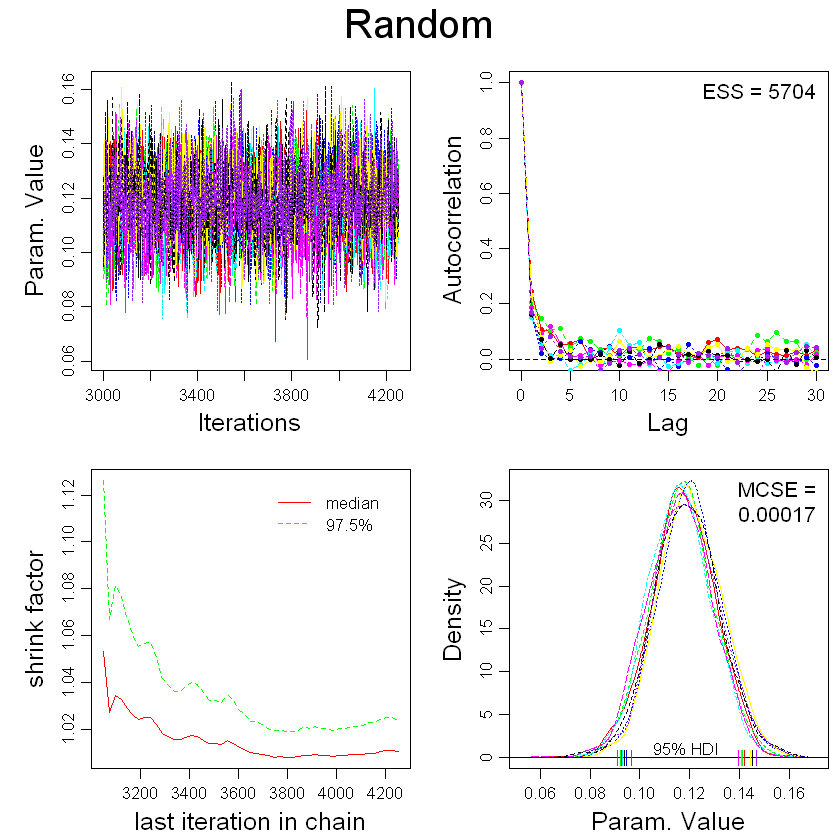

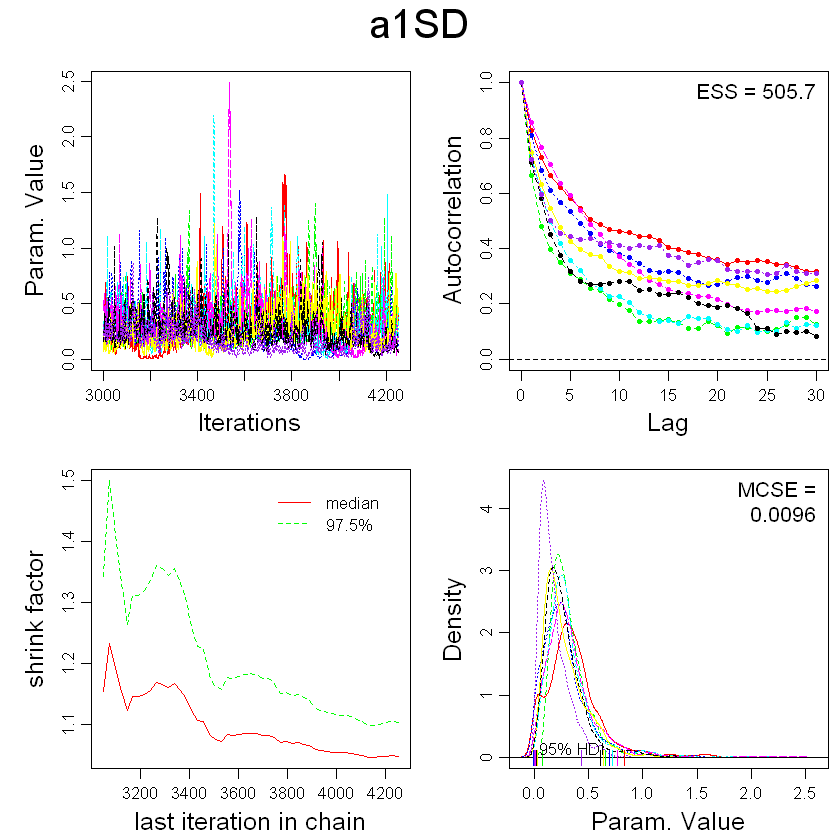

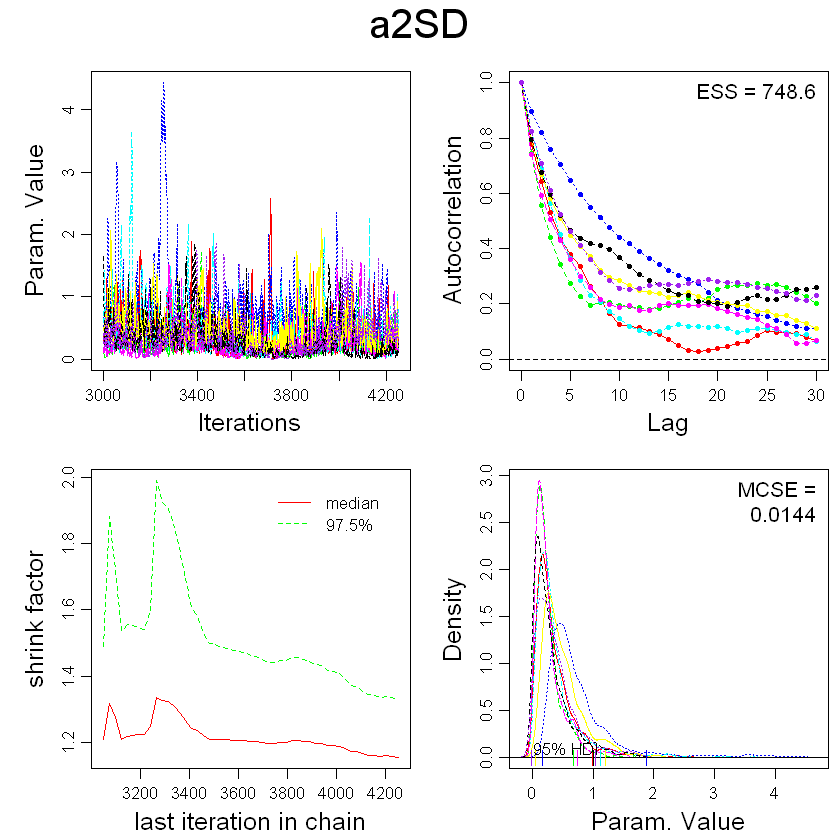

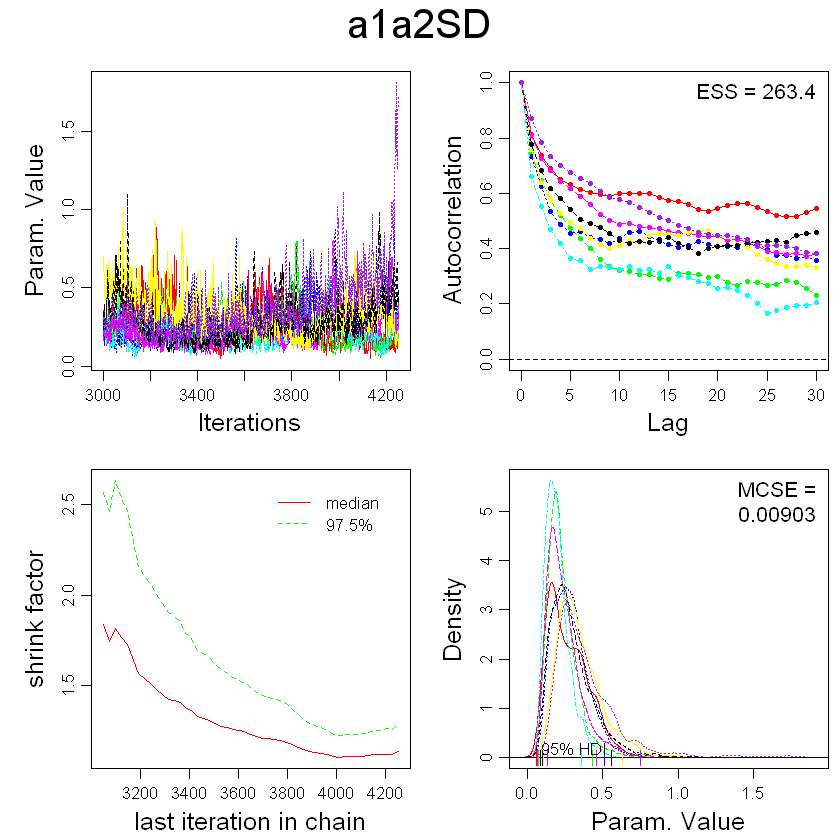

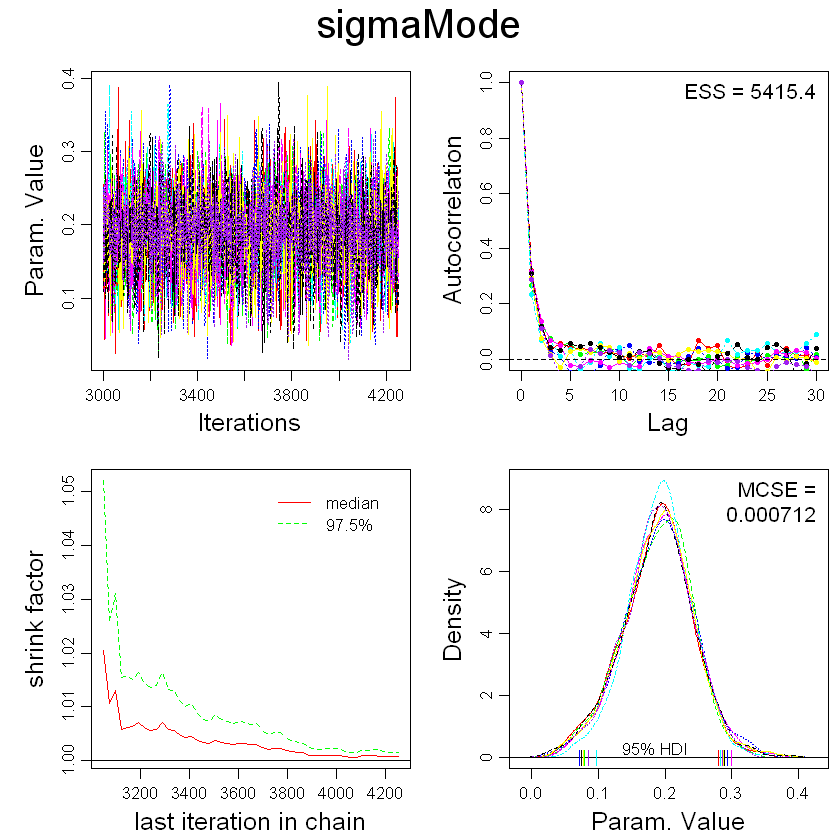

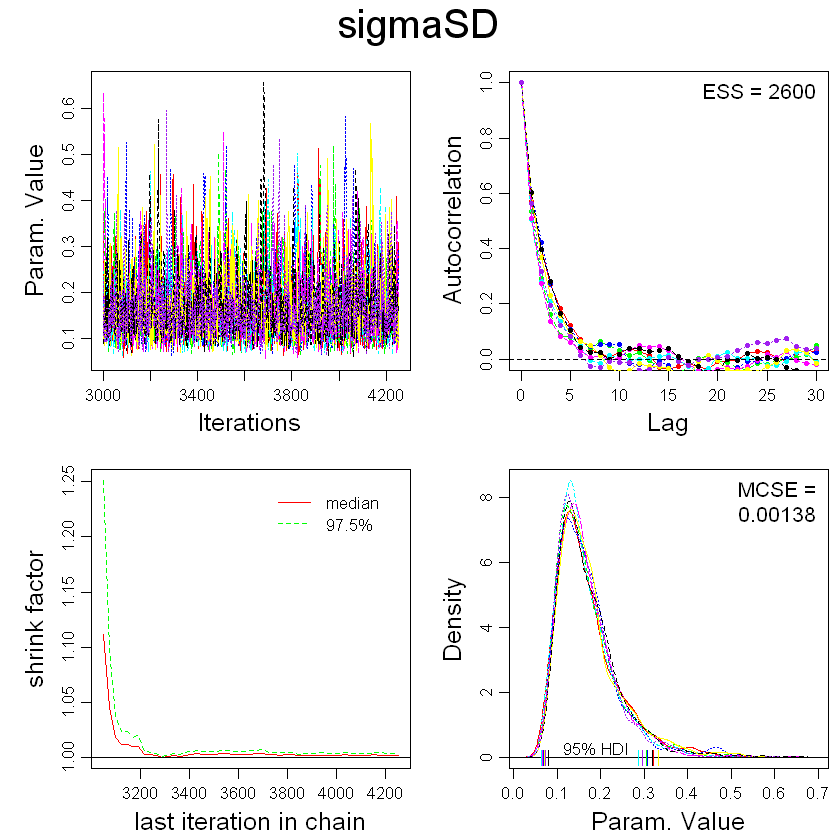

ERROR: Error in mcmcMat[chnIdx, paste0("m[", x1idx, ",", x2idx, "]")]: subscript out of bounds


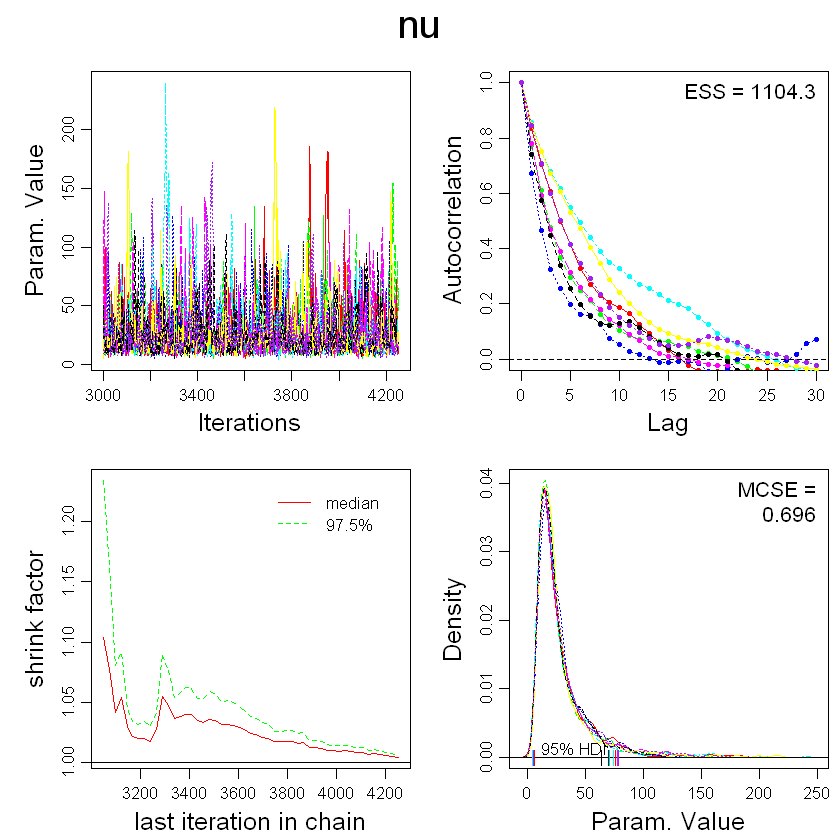

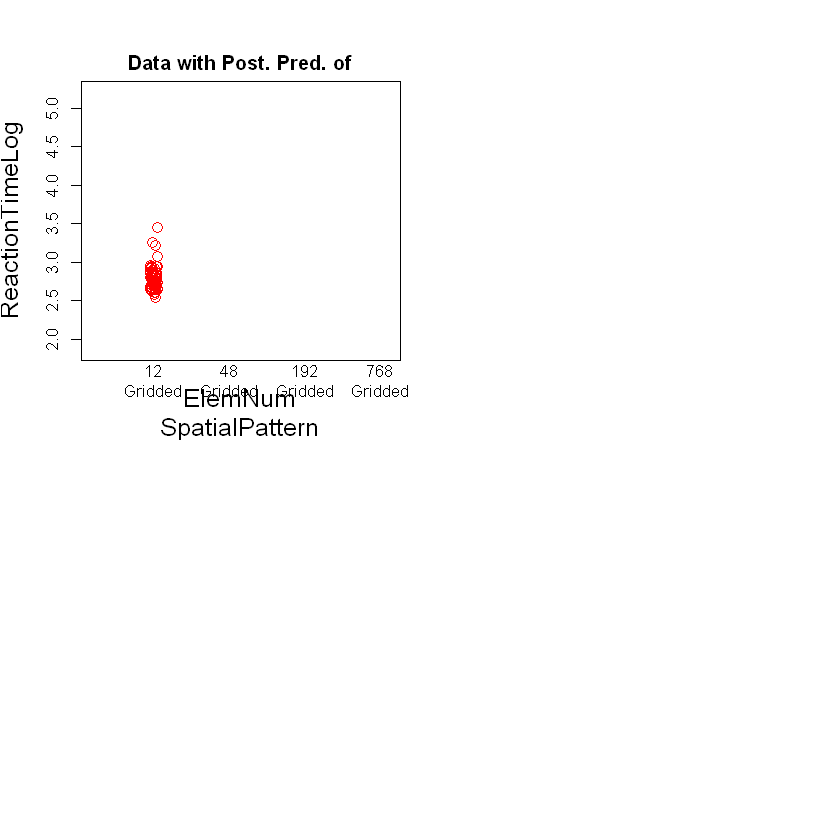

In [71]:
summaryAndPlot(paras_L, mcmcCoda_L, length_df)

### 9.3). Show shape analysis results

                               Mean       Median          Mode    ESS HDImass
b0                       3.30161868  3.301435000  3.2996874516 8065.5    0.95
b1[1] 12                -0.26500373 -0.265119000 -0.2663749007 5648.4    0.95
b1[2] 48                -0.11682019 -0.117079000 -0.1211083749 4900.2    0.95
b1[3] 192                0.14343704  0.143615000  0.1437504689 6469.7    0.95
b1[4] 768                0.23838686  0.237775500  0.2319333259 5435.2    0.95
b2[1] Gridded           -0.02468600 -0.024408550 -0.0269248204 2119.6    0.95
b2[2] Random             0.02468600  0.024408550  0.0269248204 2119.6    0.95
b1b2[1,1] 12 Gridded     0.01099727  0.008418385  0.0009571578 1139.8    0.95
b1b2[2,1] 48 Gridded     0.01638607  0.013027350  0.0018432460  821.6    0.95
b1b2[3,1] 192 Gridded   -0.01392013 -0.010354850 -0.0012234229 1406.8    0.95
b1b2[4,1] 768 Gridded   -0.01346321 -0.009652005 -0.0011359809 1451.3    0.95
b1b2[1,2] 12 Random     -0.01099727 -0.008418385 -0.0009571578 1

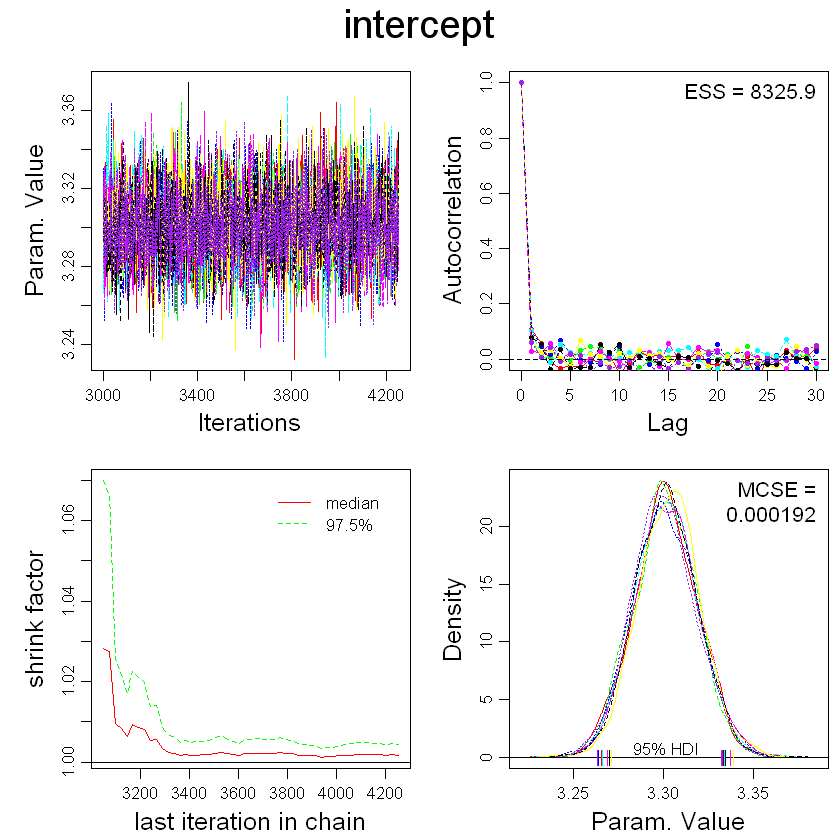

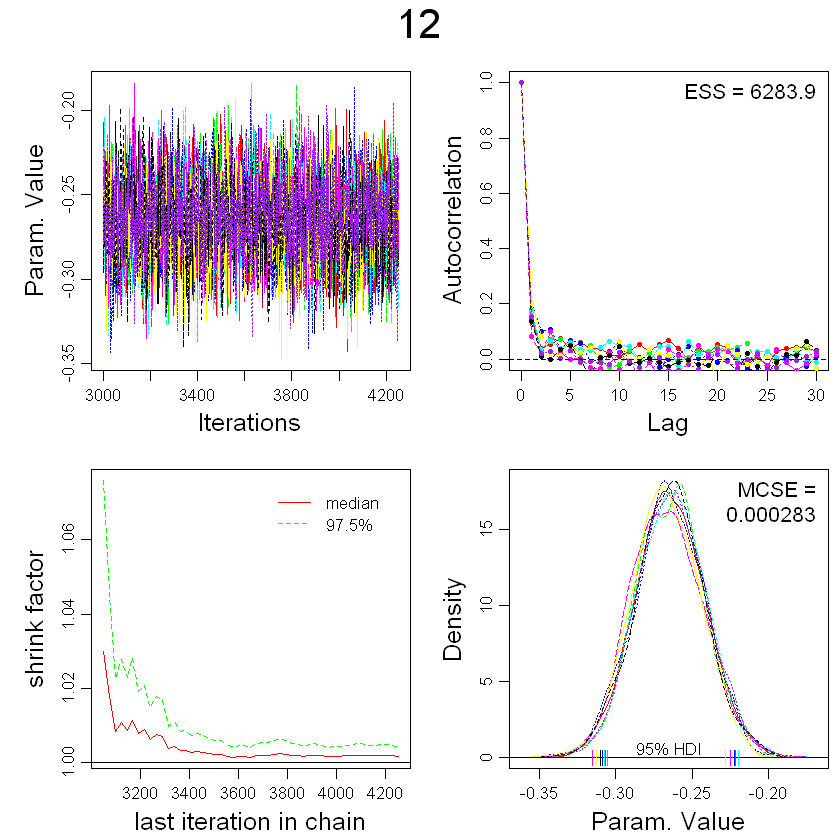

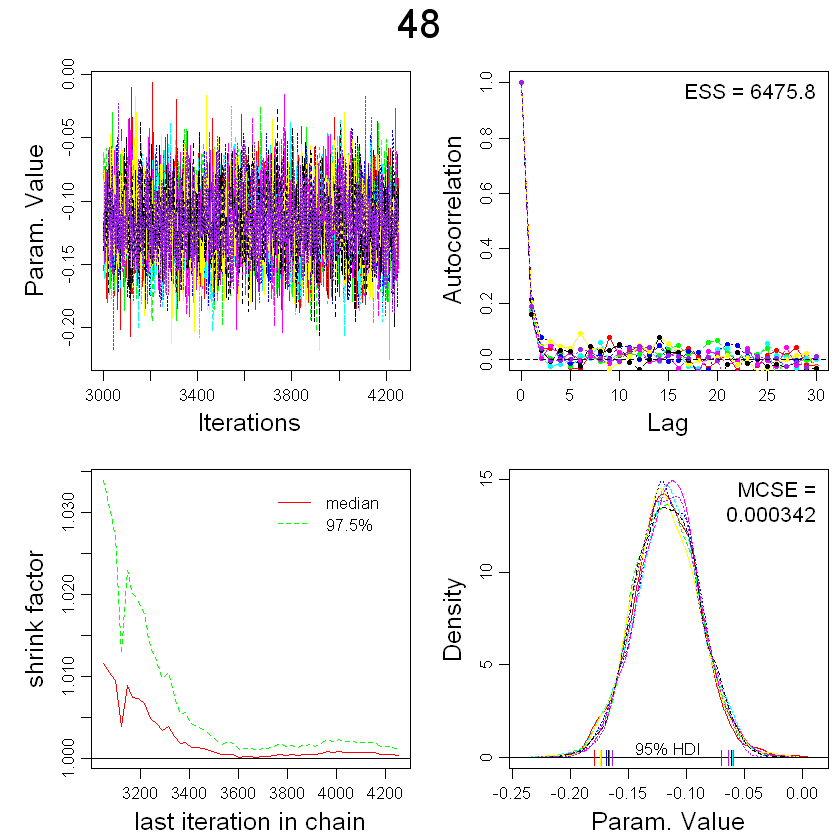

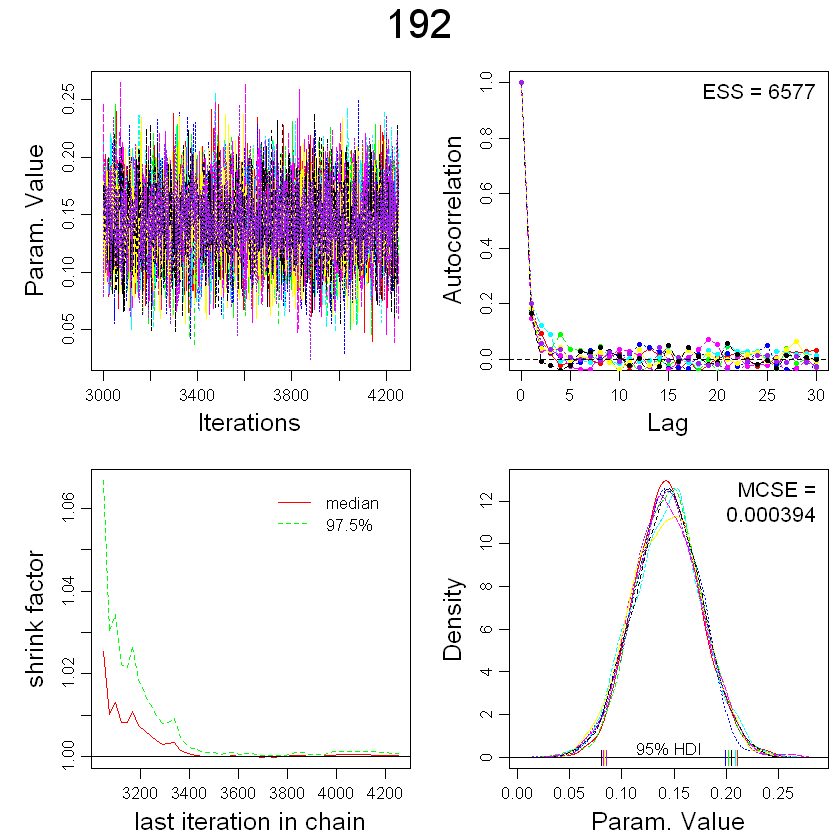

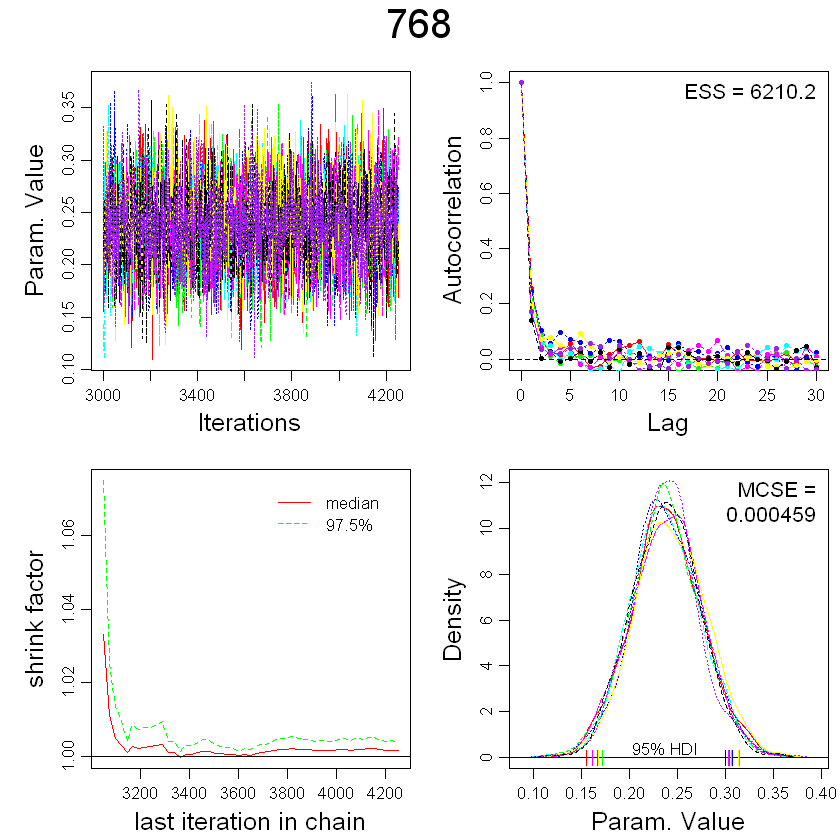

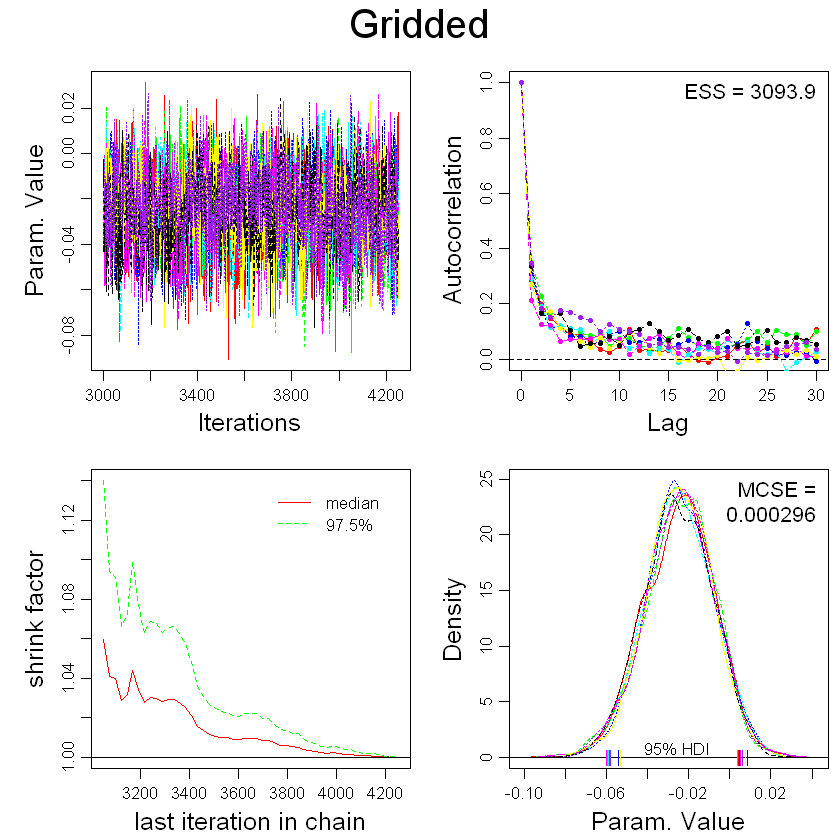

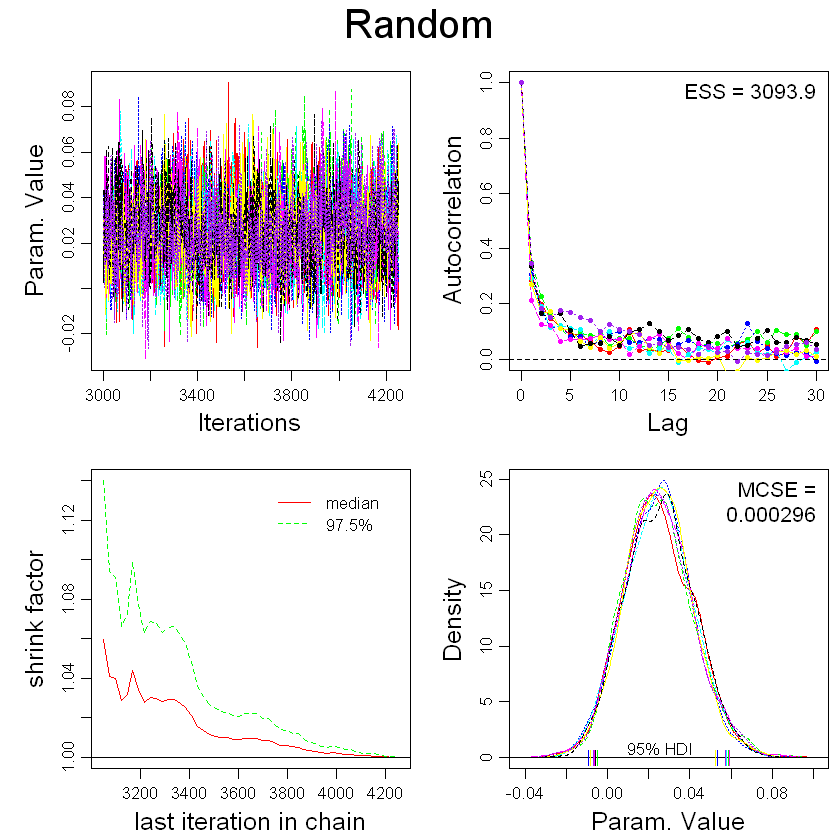

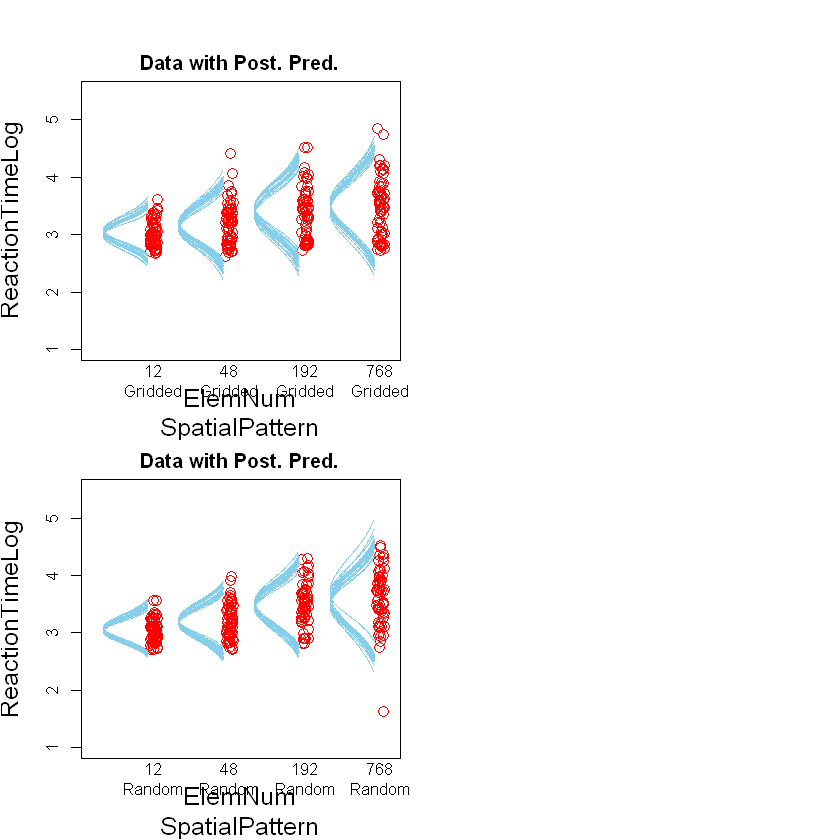

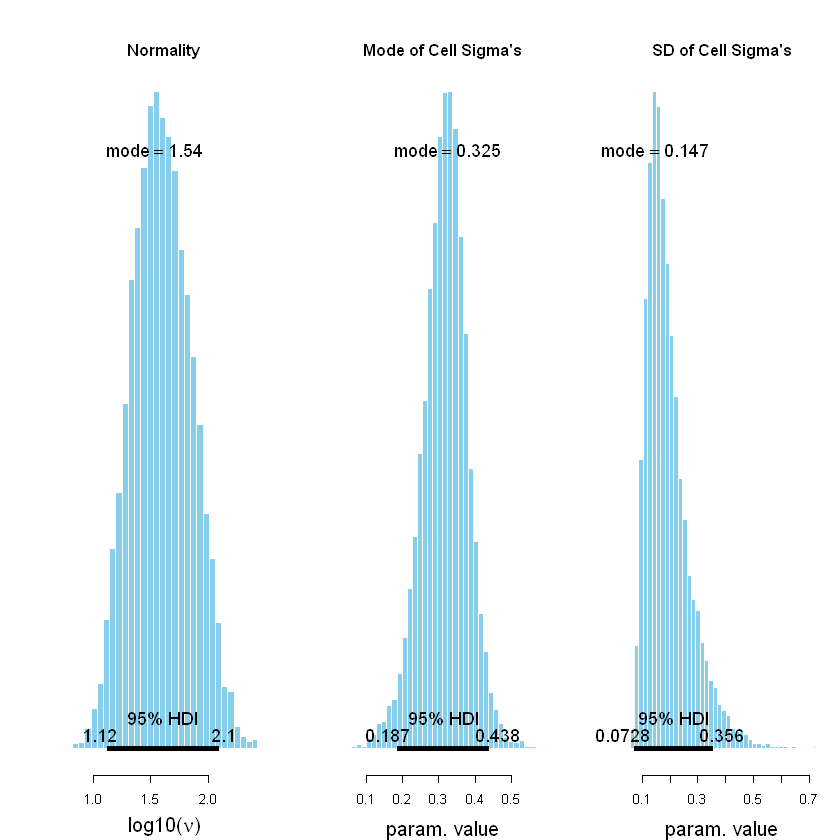

In [20]:
summaryAndPlot(paras_S, mcmcCoda_S, shape_df)

## 10). Plot contrast

### 10.1). Contrast of element number for hue

 chr [1:4] "12" "48" "192" "768"
[1] "12 - 48 probVar1Larger: 0.00699440447641886"


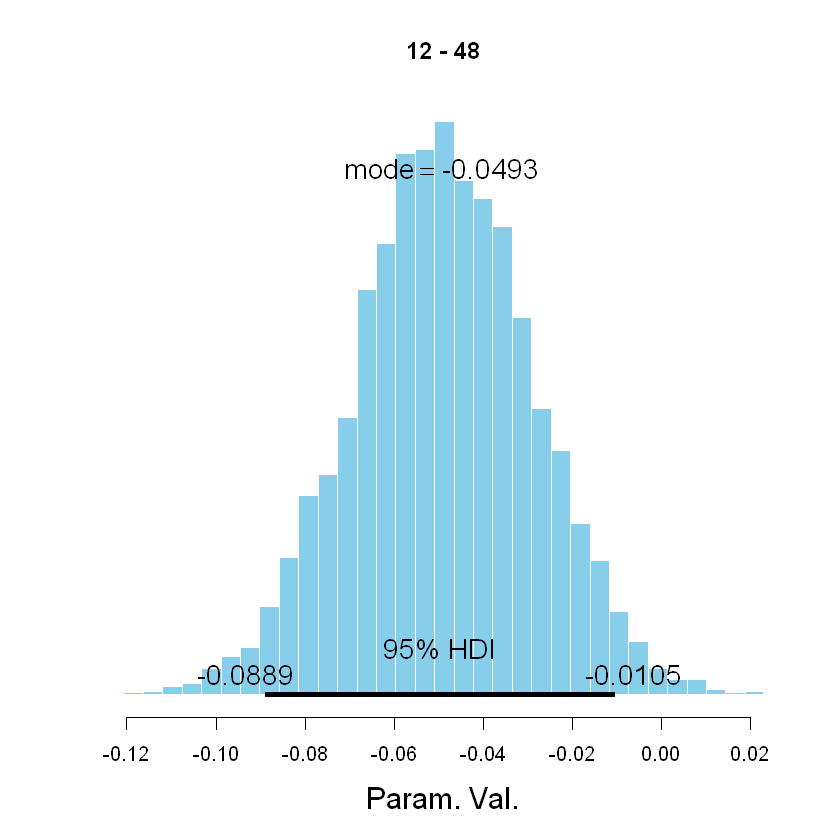

[1] "12 - 192 probVar1Larger: 0.15777378097522"


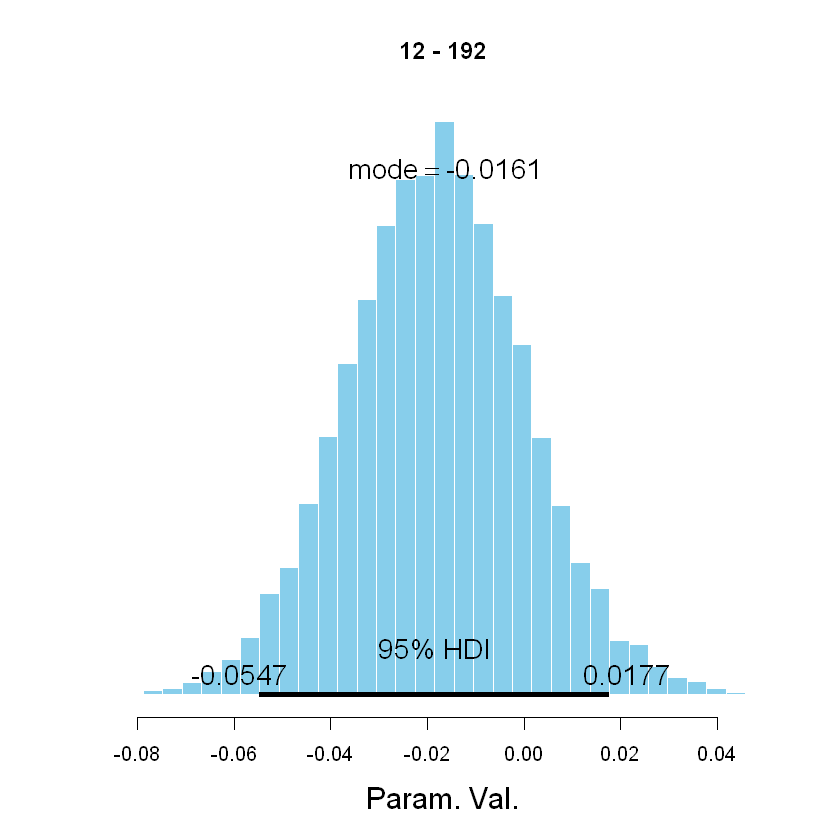

[1] "12 - 768 probVar1Larger: 0.000999200639488409"


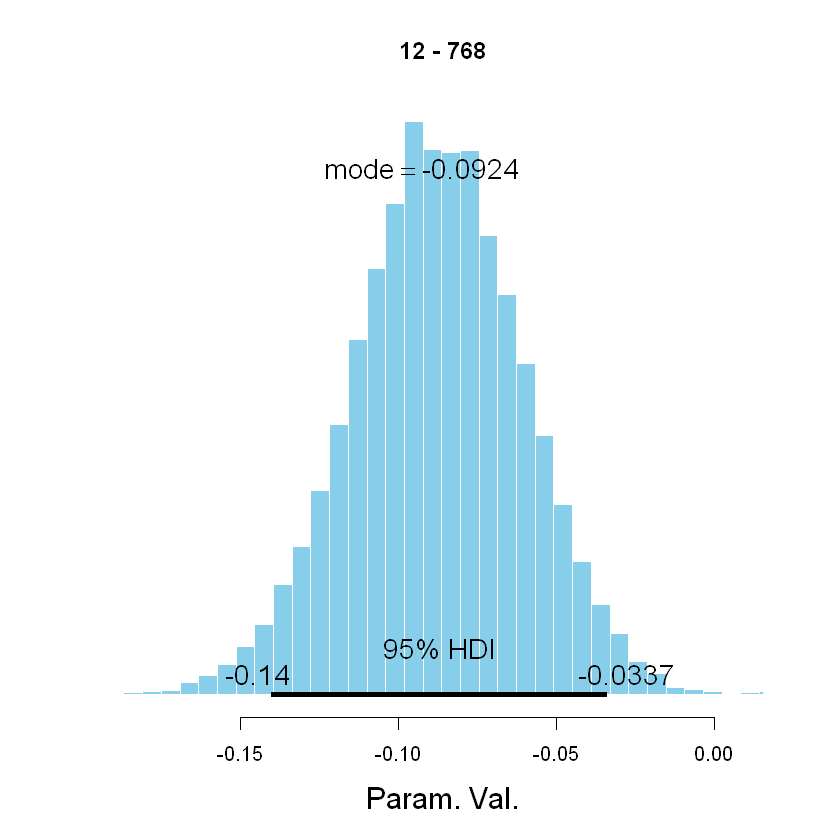

[1] "48 - 192 probVar1Larger: 0.943844924060751"


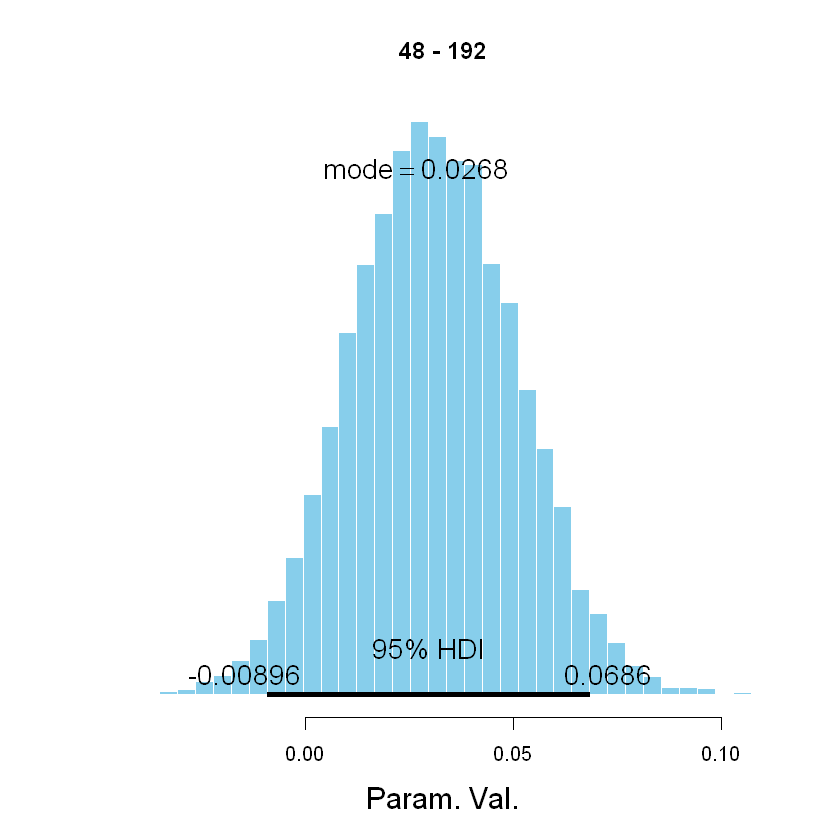

[1] "48 - 768 probVar1Larger: 0.0734412470023981"


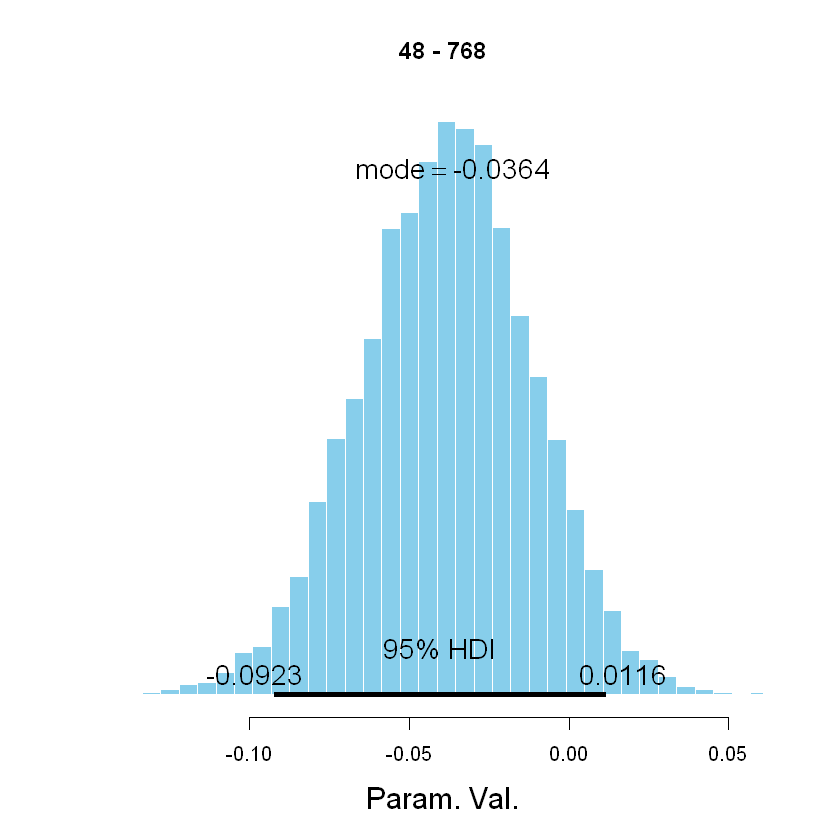

[1] "192 - 768 probVar1Larger: 0.00359712230215827"
List of 4
 $ 12 :List of 3
  ..$ 48 :List of 1
  .. ..$ probVar1Larger: num 0.00699
  ..$ 192:List of 1
  .. ..$ probVar1Larger: num 0.158
  ..$ 768:List of 1
  .. ..$ probVar1Larger: num 0.000999
 $ 48 :List of 2
  ..$ 192:List of 1
  .. ..$ probVar1Larger: num 0.944
  ..$ 768:List of 1
  .. ..$ probVar1Larger: num 0.0734
 $ 192:List of 1
  ..$ 768:List of 1
  .. ..$ probVar1Larger: num 0.0036
 $ 768: list()


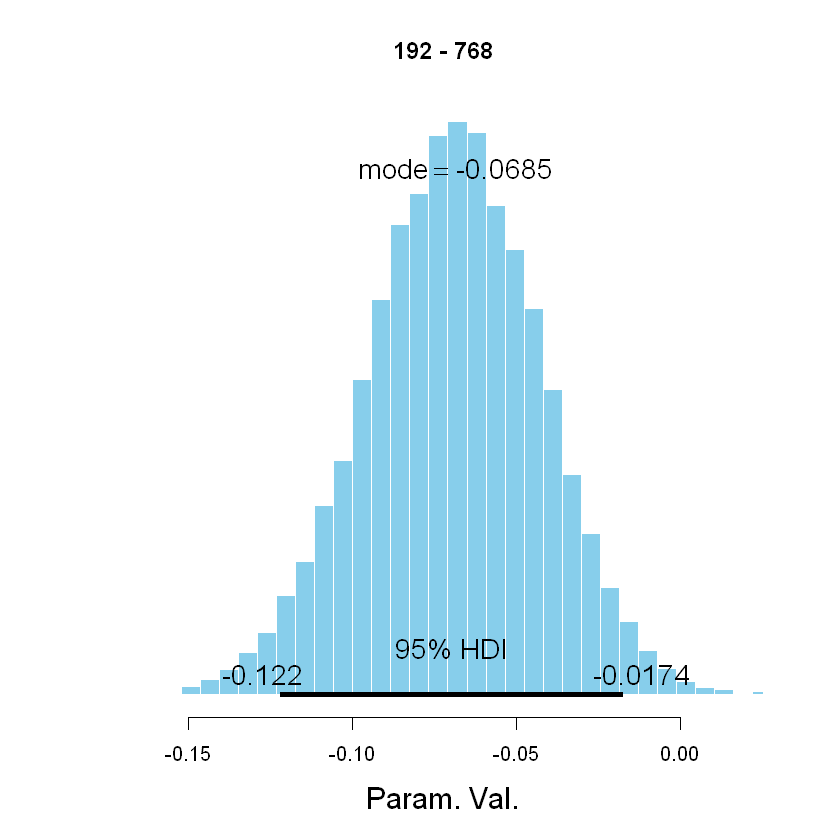

In [62]:
timeLogNumericOutput = calcAndPlotContrasts(mcmcCoda,currentdf,x1Name)
str(timeLogNumericOutput)

### 10.2). Contrast of spatial pattern for hue

 chr [1:2] "Gridded" "Random"
[1] "Gridded - Random probVar1Larger: 0.00699440447641886"
List of 2
 $ Gridded:List of 1
  ..$ Random:List of 1
  .. ..$ probVar1Larger: num 0.00699
 $ Random : list()


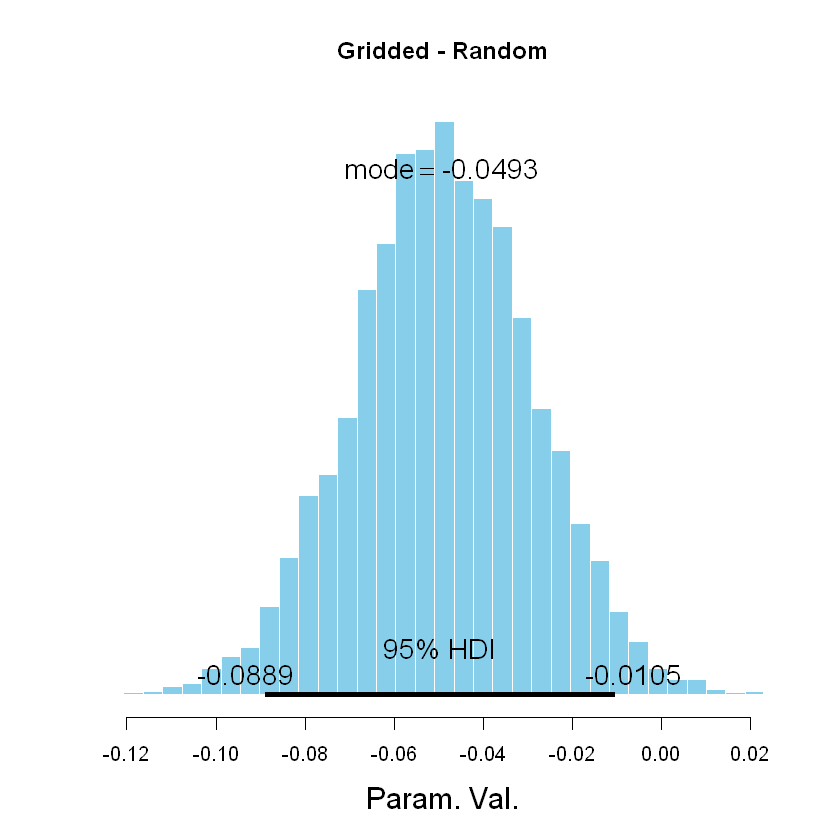

In [63]:
timeLogNumericOutput = calcAndPlotContrasts(mcmcCoda,currentdf,x2Name)
str(timeLogNumericOutput)

## 11). Analysis Results

### 11.0). Auxilary functions

In [45]:
getIntervals = function(mcmcCoda)
{
    relevantVarNames = list("12","48","192","768")
    
    # added factors
    datMat = as.matrix(mcmcCoda,chains=TRUE)   
    datFrame = data.frame(datMat)
    datFrame$c1 = datFrame$b0 + datFrame$b1.1. 
    datFrame$c2 = datFrame$b0 + datFrame$b1.2. 
    datFrame$c3 = datFrame$b0 + datFrame$b1.3. 
    datFrame$c4 = datFrame$b0 + datFrame$b1.4. 
    
    datFrameC = data.frame(datFrame[,c("c1","c2","c3","c4")])
    names(datFrameC) = relevantVarNames
    #timeLogFrameC
    
    q1 = quantile(datFrameC[["12"]],probs=c(0.025,0.5,0.975))
    q2 = quantile(datFrameC[["48"]],probs=c(0.025,0.5,0.975))
    q3 = quantile(datFrameC[["192"]],probs=c(0.025,0.5,0.975))
    q4 = quantile(datFrameC[["768"]],probs=c(0.025,0.5,0.975))
    
    
    low = c(q1[1],q2[1],q3[1],q4[1])
    mid = c(q1[2],q2[2],q3[2],q4[2])
    high = c(q1[3],q2[3],q3[3],q4[3])
    
    datIntervals = data.frame(elemNum=unlist(relevantVarNames, use.names = FALSE),low=low,mid=mid,high=high)
    datIntervals$qlowl = lapply(datIntervals$low,FUN=invlogit)
    datIntervals$qmidl = lapply(datIntervals$mid,FUN=invlogit)
    datIntervals$qhighl = lapply(datIntervals$high,FUN=invlogit)
    return (datIntervals)
}

# plot
plotAnaResults = function(datIntervals)
{
    chartHueLogit = ggplot() +
      #geom_violin(data=dfa,linetype="blank",bw=0.05,aes(x=factor(Condition),y=hue,fill=Condition)) +
      scale_fill_manual(values=c("#fbb4ae", "#b3cde3", "#ccebc5","#decbe4")) + 
      theme(panel.background = element_rect(fill = "#F6F6F6", colour = "#F6F6F6", size = 0, linetype = "solid"),
            legend.position = "none",axis.title.x = element_blank(),
            axis.text=element_text(size=14),axis.title.y=element_text(size=14)) +
      ylab("Theta (Prob. of hue Trial)") +
      #coord_cartesian(ylim = c(0, 10)) + 
      # coord_fixed(ratio = 500000000000,ylim=c(0.99999999999,1)) +
      geom_point(data=datIntervals,aes(x=factor(elemNum, levels = c("12", "48", "192", "768"), ordered = TRUE),y=invlogit(mid)))+
      geom_errorbar(data=datIntervals,aes(x=factor(elemNum, levels = c("12", "48", "192", "768"),ordered = TRUE),ymin=invlogit(low), ymax=invlogit(high)), width=.3)  +
      geom_text(data=datIntervals,size=5,aes(x=factor(elemNum, levels = c("12", "48", "192", "768"),ordered = TRUE),y=0.95, label=paste(format(invlogit(mid)*100, digits = 4),"%",sep="")))
    
    plot(chartHueLogit)
    
    # plot
    charthue = ggplot() +
      # geom_violin(data=dfa,linetype="blank",bw=0.05,aes(x=factor(Condition),y=hue,fill=Condition)) +
      scale_fill_manual(values=c("#fbb4ae", "#b3cde3", "#ccebc5","#decbe4")) + 
      theme(panel.background = element_rect(fill = "#F6F6F6", colour = "#F6F6F6", size = 0, linetype = "solid"),
            legend.position = "none",axis.title.x = element_blank(),
            axis.text=element_text(size=14),axis.title.y=element_text(size=14)) +
      ylab("Theta (Prob. of hue Trial)") +
      #coord_cartesian(ylim = c(0, 10)) + 
      #coord_fixed(ratio = 0.1,ylim=c(0,50)) +
      geom_point(data=datIntervals,aes(x=factor(elemNum, levels = c("12", "48", "192", "768"), ordered = TRUE),y=mid))+
      geom_errorbar(data=datIntervals,aes(x=factor(elemNum, levels = c("12", "48", "192", "768"), ordered = TRUE),ymin=low, ymax=high), width=.3)  +
      geom_text(data=datIntervals,size=5,aes(x=factor(elemNum, levels = c("12", "48", "192", "768"), ordered = TRUE),y=0.95, label=paste(format(10**mid, digits = 4),"ms",sep="")))
    
    plot(charthue)
    
    # postFileName = paste(resultsGraphicsDir,"vertical-graph-hue.pdf",sep="")
    #     pdf(postFileName,width=6,height=4)
    #     plot(charthue)
    #     dev.off()
}

### 11.1). Hue

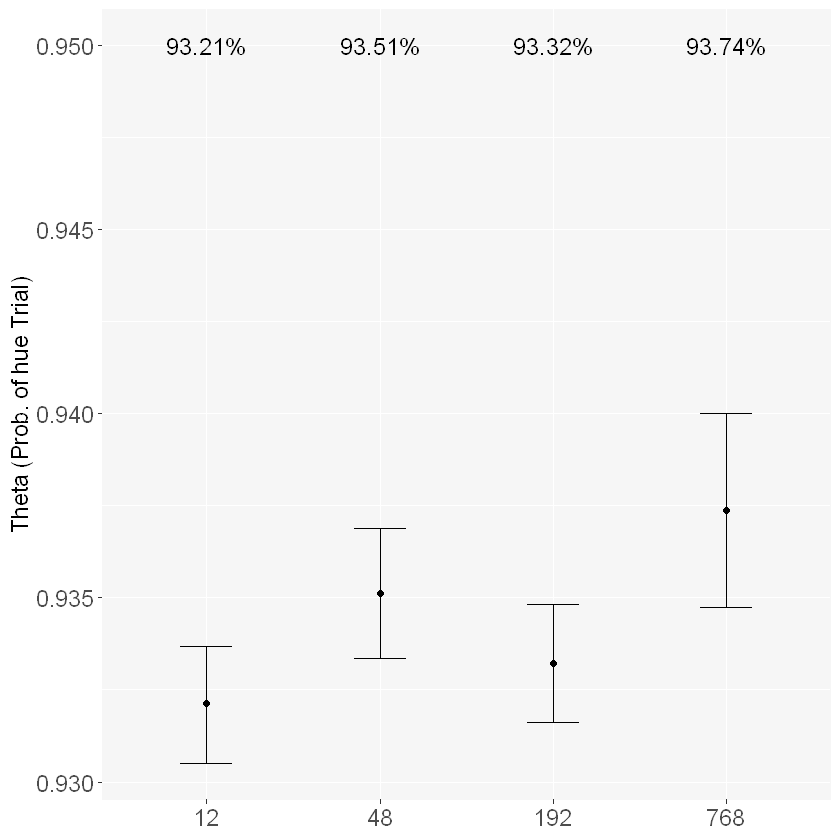

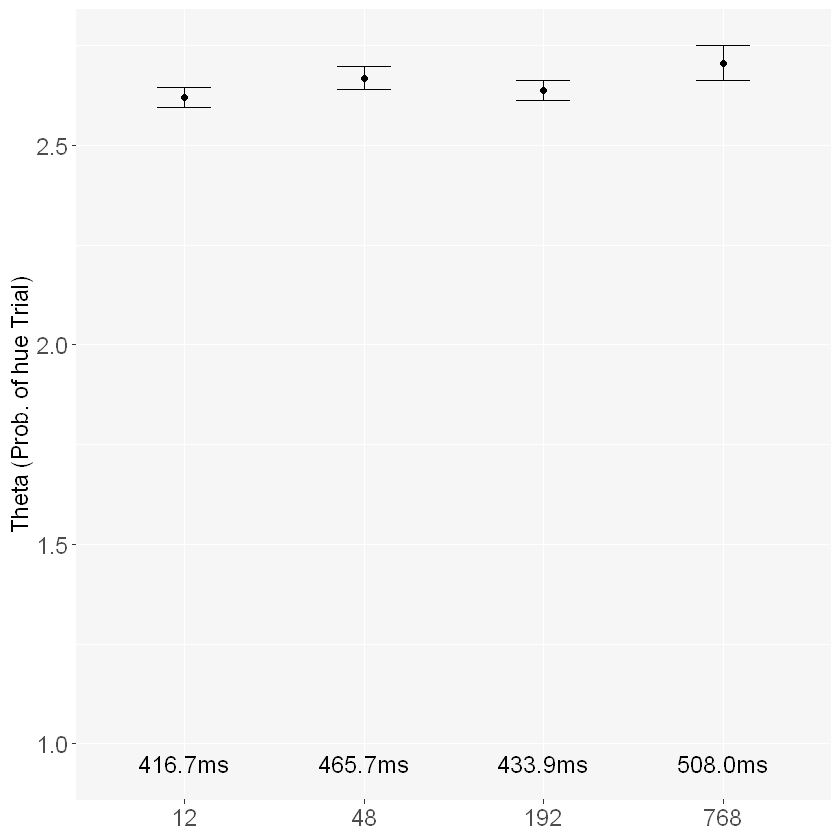

In [48]:
plotAnaResults(getIntervals(mcmcCoda_H))

### 11.2). Length

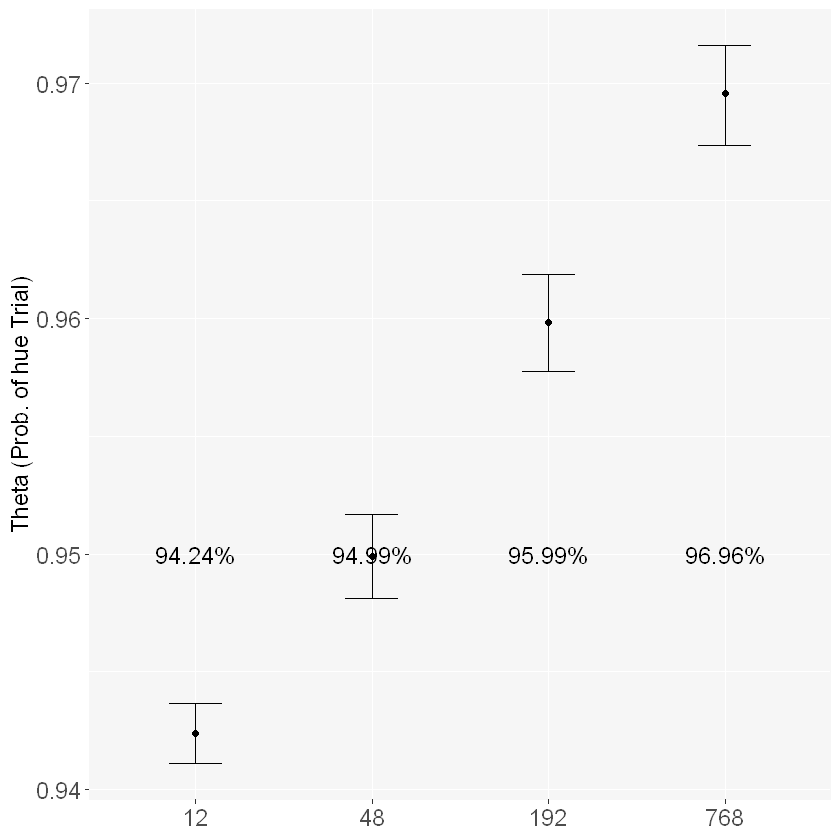

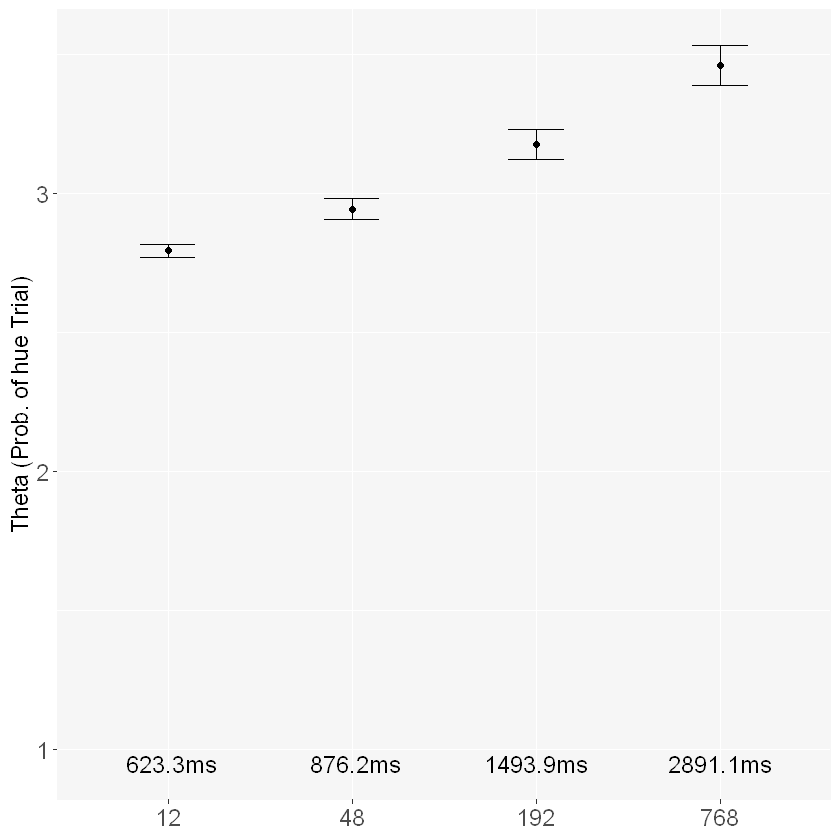

In [46]:
plotAnaResults(getIntervals(mcmcCoda_L))

### 11.3). Shape

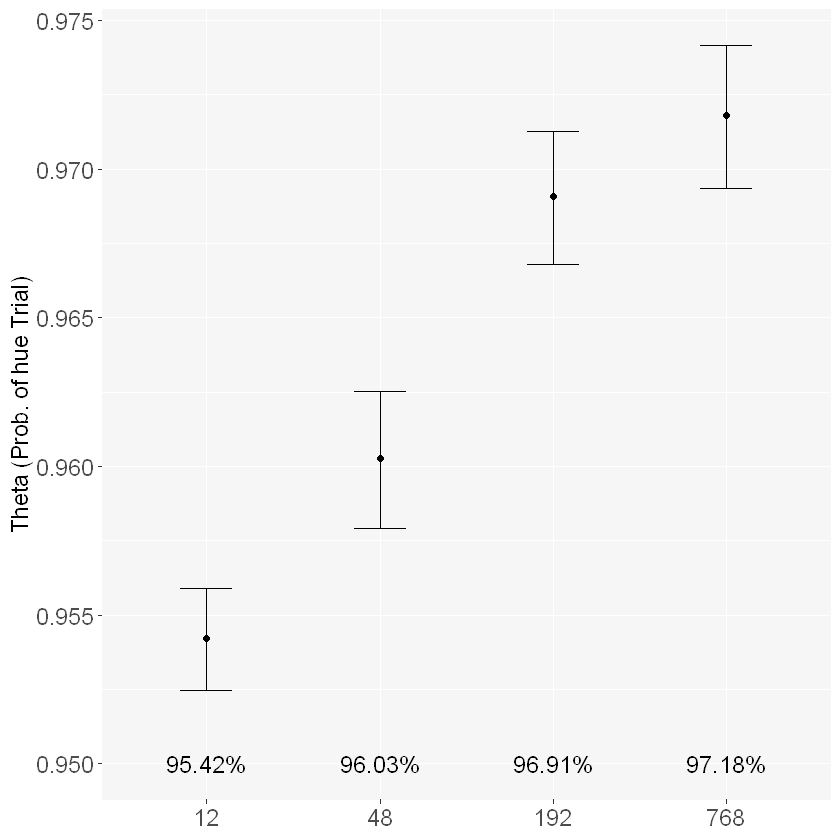

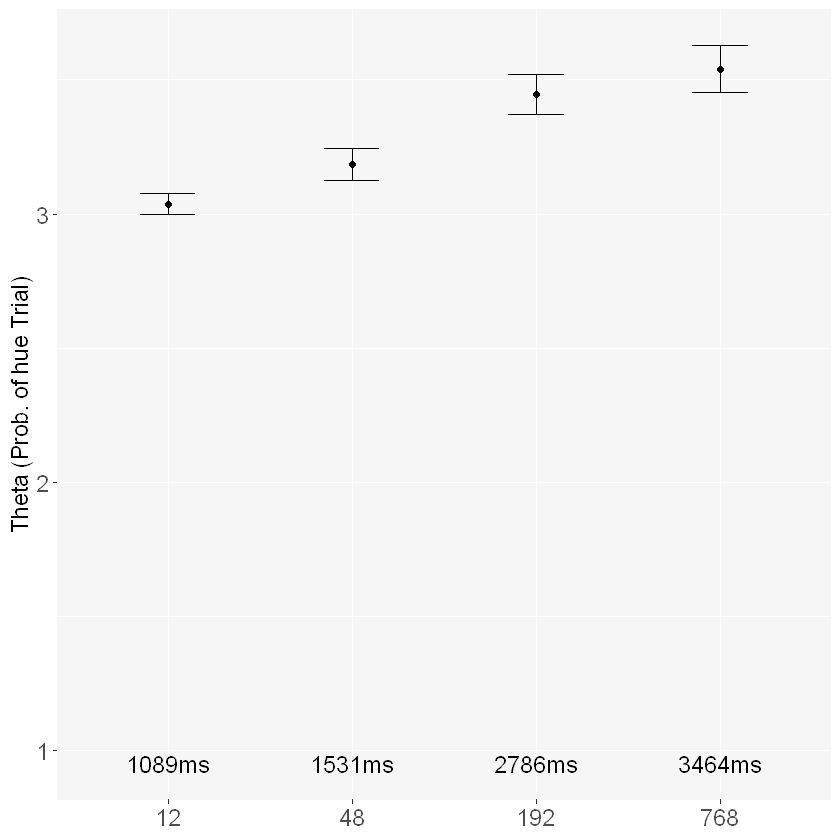

In [47]:
plotAnaResults(getIntervals(mcmcCoda_S))